# Variational Autoencoders 

Implement a variational autoencoder. Ensure you generate z using the reparameterization technique so that  backpropagation can work. Train on the MNIST database. You can downsample the images to 14 × 14 to make your optimization converge faster.

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Get the MNIST data from keras, downsample and save to csv file
# No need to run this chunk of code again as csv files with 14x14 images are saved 
# Each image is saved as 196 dim vector with label as it's label
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train, _),(x_test, _) = mnist.load_data()

x_train = np.reshape(x_train, newshape=(*x_train.shape, 1))
x_train = tf.image.resize_images(images=x_train, size=(14,14))
x = tf.Session().run(x_train)
x_train = np.asarray(x, dtype=np.uint8).reshape(x_train.shape[0], 196) / 255.
# pd.DataFrame(x_train).to_csv('train.csv', sep=',', index=True, header=False)

x_test = np.reshape(x_test, newshape=(*x_test.shape, 1))
x_test = tf.image.resize_images(images=x_test, size=(14,14))
x = tf.Session().run(x_test)
x_test = np.asarray(x, dtype=np.uint8).reshape(x_test.shape[0], 196) / 255.
# pd.DataFrame(x_test).to_csv('train.csv', sep=',', index=True, header=False)

In [3]:
import matplotlib.pyplot as plt
def show_digit(x): # x - 196 dim vector
    x = np.reshape(x, (14,14))
    fig = plt.figure(figsize=(2, 2))
    fig.add_subplot(1,1,1)
    plt.imshow(x, cmap='gray')
#     fig.add_subplot(1,2,2)
#     plt.imshow(y, cmap='gray')    
    plt.show()


### Loss Function

$$L = \|\hat{Y} - X\|^{2} + D_{KL}\big[\mathcal{N}(\mu(X),exp\Sigma(X)) \| \mathcal{N}(0,1)\big]$$

$$D_{KL}\big[\mathcal{N}(\mu(X),\Sigma(X)) \| \mathcal{N}(0,1)\big] = \frac{1}{2}\sum_{k}\Big(exp\Sigma(X) + \mu^{2}(X) -1 - \Sigma(X)\Big)$$



In [4]:
class VAE():
    def __init__(self, input_dim, latent_dim, learn_rate):
        self.input_dim = input_dim
        self.learn_rate = learn_rate
        self.latent_dim = latent_dim
        self.output_dim = input_dim
        # intialize weights
        # Weights and Biases of input to mean
        self.U = np.random.normal(0, 1, (self.latent_dim, self.input_dim))
        self.u0 = np.random.normal(0, 1, self.latent_dim)
        # weights and biases of input to covariance
        self.V = np.random.normal(0, 1, (self.latent_dim, self.input_dim))
        self.v0 = np.random.normal(0, 1, self.latent_dim)
        # weights and biases of latent variable to output
        self.W = np.random.normal(0, 1, (self.output_dim, self.latent_dim))
        self.w0 = np.random.normal(0, 1, self.output_dim)
        

    def sigmoid(self, t):
        return 1/(1  + np.exp(-t))

    def dsigmoid(self, t):
        sigt = self.sigmoid(t)
        return sigt*(1-sigt)

   
    def tanh(self, t):
        return (2*self.sigmoid(2*t) - 1)
    
    def dtanh(self, t):
        return (1 - self.tanh(x)**2)

    def encoder(self, x):
        mean = self.tanh(np.dot(x, self.U.T) + self.u0)
        log_covar = self.tanh(np.dot(x, self.V.T) + self.v0)
        return [mean, log_covar] 

    def decoder(self, z):
        return self.sigmoid(np.dot(z, self.W.T) + self.w0)

    def reduce_loss(self, X):
        self.N = len(X)
        #print(X.shape)
        # derivative of loss w.r.t weights and biases
        dLoss_U, dLoss_u0 = np.zeros_like(self.U), np.zeros_like(self.u0)
        dLoss_V, dLoss_v0 = np.zeros_like(self.V), np.zeros_like(self.v0)
        dLoss_W, dLoss_w0 = np.zeros_like(self.W), np.zeros_like(self.w0)
        # mean.shape, covar.shape = (N,k) 
        [mean, log_covar] = self.encoder(X) # mean, log_covar
        covar = np.exp(log_covar)
        e = np.random.normal(0, 1, mean.shape)
        Z = (covar* e) + mean
        # Y.shape = (N, d)
        Y = self.decoder(Z)
        # dY = dsigmoid(np.dot(z, W.T) + w0)
        # dY computed in this way and stored to avoid repeated calling of sigmoid function
        dY = Y * (1-Y)
        # similarly, derivative of tanh = 1 - tanh**2
        dmean = 1 - mean**2
        dlog_covar = 1 - log_covar**2
        self.loss += np.linalg.norm(Y-X)**2 + 0.5*np.sum((covar - mean**2 -1 - log_covar))
        # y_delta.shape (N,d)
        y_delta = 2* (Y-X) * dY
        # mean.shape (N,k)
        mean_delta = np.multiply(np.matmul(y_delta, self.W), dmean) 
        dKL_U = np.sum(mean*dmean, axis=1) # shape = (N,)
        covar_delta = np.matmul(y_delta, self.W) * e * covar * dlog_covar
        dKL_V = 0.5 * np.sum((covar-1)*dlog_covar, axis=1)

        dLoss_W = np.matmul(y_delta.T, Z)
        dLoss_w0 = np.sum(y_delta, axis=0)
        dLoss_U = np.matmul((mean_delta.T + dKL_U) , X)
        dLoss_u0 = np.sum(mean_delta.T + dKL_U, axis=1)
        dLoss_V = np.matmul((covar_delta.T + dKL_V) , X)
        dLoss_v0 = np.sum((covar_delta.T + dKL_V), axis=1)
        # update weights 
        self.U  -= self.learn_rate * dLoss_U
        self.u0 -= self.learn_rate * dLoss_u0
        self.V  -= self.learn_rate * dLoss_V
        self.v0 -= self.learn_rate * dLoss_v0
        self.W  -= self.learn_rate * dLoss_W
        self.w0 -= self.learn_rate * dLoss_w0
    
    
    def train(self, x_train, epochs, batch_size, shuffle=True): 
        N = len(x_train)
        epoch = 1
        while(epoch <= epochs):
            if shuffle:
                indices = np.arange(len(x_train))
                np.random.shuffle(indices)
                x_train = x_train[indices]
            self.loss = 0
            for batch in np.arange(0, N, batch_size):
                X = x_train[batch:batch+batch_size]
                self.reduce_loss(X=X)
                
            print('Epoch: ', epoch, ' Loss: ', self.loss)
            # show_digit(x_train[0])
            
            if epoch%5==0: 
                z = np.random.normal(0,1, self.latent_dim)
                show_digit(self.decoder(z))
            epoch += 1
        print('Done Training')

Epoch:  1  Loss:  2363527.765196852
Epoch:  2  Loss:  1133298.9704374482
Epoch:  3  Loss:  890177.862460074
Epoch:  4  Loss:  840197.832950969
Epoch:  5  Loss:  820832.4063488541


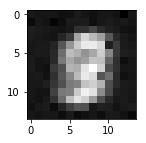

Epoch:  6  Loss:  808669.2123643975
Epoch:  7  Loss:  799961.0937805898
Epoch:  8  Loss:  793678.518097887
Epoch:  9  Loss:  790043.8128591689
Epoch:  10  Loss:  786707.1886600954


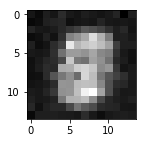

Epoch:  11  Loss:  783808.7747492144
Epoch:  12  Loss:  781335.4110318335
Epoch:  13  Loss:  779198.2582875572
Epoch:  14  Loss:  777622.7359726087
Epoch:  15  Loss:  776286.656861028


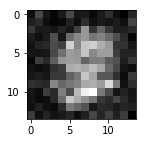

Epoch:  16  Loss:  774395.4322640003
Epoch:  17  Loss:  773653.1342687923
Epoch:  18  Loss:  772481.4151950962
Epoch:  19  Loss:  771354.8102342647
Epoch:  20  Loss:  770468.8334058677


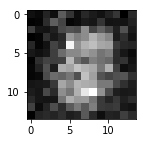

Epoch:  21  Loss:  769548.3630482556
Epoch:  22  Loss:  768714.5454351787
Epoch:  23  Loss:  767898.4709855006
Epoch:  24  Loss:  767631.574724995
Epoch:  25  Loss:  766642.8706427572


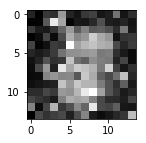

Epoch:  26  Loss:  766118.0735087204
Epoch:  27  Loss:  765713.5266340235
Epoch:  28  Loss:  765174.9843007191
Epoch:  29  Loss:  765058.3113309736
Epoch:  30  Loss:  764464.8920098025


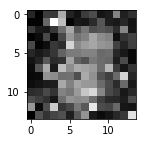

Epoch:  31  Loss:  764191.7295458888
Epoch:  32  Loss:  763811.1147733368
Epoch:  33  Loss:  763379.2452544698
Epoch:  34  Loss:  763014.4658691451
Epoch:  35  Loss:  762899.0182670766


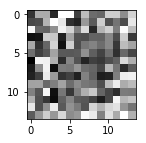

Epoch:  36  Loss:  762700.4652849376
Epoch:  37  Loss:  762511.0225230012
Epoch:  38  Loss:  761949.0701072362
Epoch:  39  Loss:  761668.4538247883
Epoch:  40  Loss:  761428.4983554044


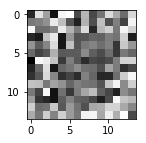

Epoch:  41  Loss:  761460.4320265192
Epoch:  42  Loss:  760922.3390999109
Epoch:  43  Loss:  760957.0811071002
Epoch:  44  Loss:  760707.2782556302
Epoch:  45  Loss:  760541.0383588398


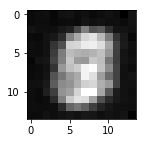

Epoch:  46  Loss:  760347.5444755236
Epoch:  47  Loss:  760175.8444186185
Epoch:  48  Loss:  760146.9973870339
Epoch:  49  Loss:  759949.3894177382
Epoch:  50  Loss:  759876.654183505


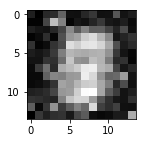

Epoch:  51  Loss:  759611.4003556304
Epoch:  52  Loss:  759461.106042427
Epoch:  53  Loss:  759304.7352996058
Epoch:  54  Loss:  759189.2724747125
Epoch:  55  Loss:  759275.614418791


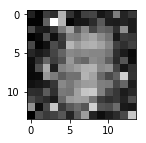

Epoch:  56  Loss:  758907.7512287323
Epoch:  57  Loss:  759022.6235791357
Epoch:  58  Loss:  758854.9327871043
Epoch:  59  Loss:  758859.6114863098
Epoch:  60  Loss:  758669.0831521554


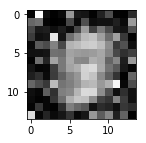

Epoch:  61  Loss:  758495.5546119886
Epoch:  62  Loss:  758449.4730446358
Epoch:  63  Loss:  758392.5285129191
Epoch:  64  Loss:  758299.2428720152
Epoch:  65  Loss:  758223.2992121737


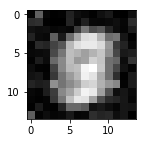

Epoch:  66  Loss:  758125.2117791058
Epoch:  67  Loss:  757931.256546158
Epoch:  68  Loss:  757937.3630969372
Epoch:  69  Loss:  758000.5112855004
Epoch:  70  Loss:  757920.7176164461


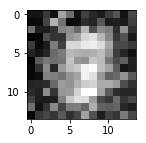

Epoch:  71  Loss:  757881.0358885268
Epoch:  72  Loss:  757852.0631504693
Epoch:  73  Loss:  757694.3493340721
Epoch:  74  Loss:  757692.1024721512
Epoch:  75  Loss:  757688.9740867978


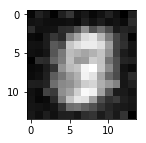

Epoch:  76  Loss:  757638.7856268544
Epoch:  77  Loss:  757437.0277657213
Epoch:  78  Loss:  757431.6077957256
Epoch:  79  Loss:  757332.6732342567
Epoch:  80  Loss:  757303.045673018


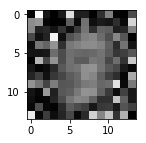

Epoch:  81  Loss:  757312.9653455783
Epoch:  82  Loss:  757181.515703013
Epoch:  83  Loss:  757276.95810292
Epoch:  84  Loss:  757047.1966680215
Epoch:  85  Loss:  757046.5389746135


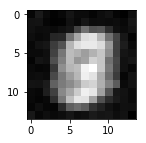

Epoch:  86  Loss:  757141.0251520023
Epoch:  87  Loss:  757026.1798319331
Epoch:  88  Loss:  757100.6222752193
Epoch:  89  Loss:  757092.7285678575
Epoch:  90  Loss:  756924.6919688358


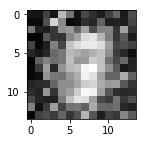

Epoch:  91  Loss:  756931.3147287548
Epoch:  92  Loss:  756815.3071570476
Epoch:  93  Loss:  756793.0742337912
Epoch:  94  Loss:  756722.3311592421
Epoch:  95  Loss:  756784.9711791923


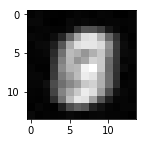

Epoch:  96  Loss:  756653.5957480922
Epoch:  97  Loss:  756627.9266556276
Epoch:  98  Loss:  756657.1343395406
Epoch:  99  Loss:  756604.5128545231
Epoch:  100  Loss:  756578.1041345202


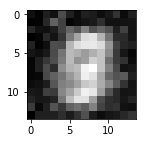

Epoch:  101  Loss:  756558.9273679178
Epoch:  102  Loss:  756460.887088341
Epoch:  103  Loss:  756393.0176586608
Epoch:  104  Loss:  756461.3319388572
Epoch:  105  Loss:  756504.7815660704


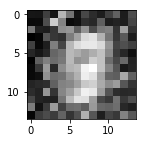

Epoch:  106  Loss:  756408.2516759157
Epoch:  107  Loss:  756452.5070387685
Epoch:  108  Loss:  756461.9225809838
Epoch:  109  Loss:  756465.6486419541
Epoch:  110  Loss:  756292.3736060006


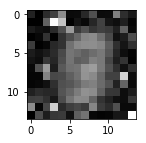

Epoch:  111  Loss:  756278.1458736839
Epoch:  112  Loss:  756284.0117799541
Epoch:  113  Loss:  756288.8608001522
Epoch:  114  Loss:  756142.4771873968
Epoch:  115  Loss:  756256.8711065691


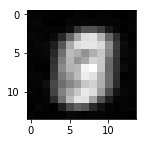

Epoch:  116  Loss:  756276.9721379572
Epoch:  117  Loss:  756147.5709602651
Epoch:  118  Loss:  756140.0623079005
Epoch:  119  Loss:  756119.0307987772
Epoch:  120  Loss:  756084.5249640776


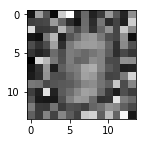

Epoch:  121  Loss:  756113.5192481095
Epoch:  122  Loss:  755980.7299824965
Epoch:  123  Loss:  756042.492954583
Epoch:  124  Loss:  756068.6079907485
Epoch:  125  Loss:  755977.8294062803


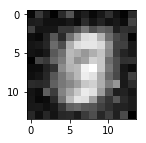

Epoch:  126  Loss:  756025.699243152
Epoch:  127  Loss:  755989.301595044
Epoch:  128  Loss:  755910.4806651709
Epoch:  129  Loss:  756039.6830124172
Epoch:  130  Loss:  755977.489112415


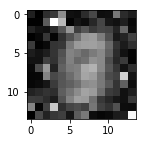

Epoch:  131  Loss:  755949.5532917578
Epoch:  132  Loss:  755936.546770238
Epoch:  133  Loss:  755907.6325156516
Epoch:  134  Loss:  755900.5802044282
Epoch:  135  Loss:  755874.0650700841


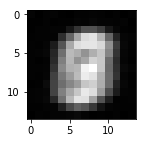

Epoch:  136  Loss:  755821.2711736728
Epoch:  137  Loss:  755886.9492432647
Epoch:  138  Loss:  755788.725128711
Epoch:  139  Loss:  755875.8465086819
Epoch:  140  Loss:  755762.6186837553


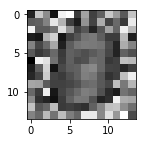

Epoch:  141  Loss:  755792.5840406369
Epoch:  142  Loss:  755731.2331055567
Epoch:  143  Loss:  755755.7072713103
Epoch:  144  Loss:  755712.7409047745
Epoch:  145  Loss:  755732.1788370773


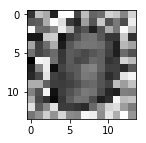

Epoch:  146  Loss:  755718.3574961809
Epoch:  147  Loss:  755706.2261390687
Epoch:  148  Loss:  755687.8700878692
Epoch:  149  Loss:  755654.8952251932
Epoch:  150  Loss:  755696.7251156081


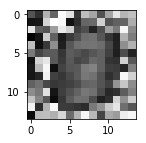

Epoch:  151  Loss:  755719.0118769648
Epoch:  152  Loss:  755669.5772612834
Epoch:  153  Loss:  755659.3518679762
Epoch:  154  Loss:  755636.8224199527
Epoch:  155  Loss:  755619.1647689777


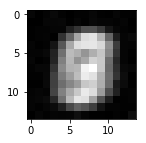

Epoch:  156  Loss:  755613.3512309245
Epoch:  157  Loss:  755608.4524221522
Epoch:  158  Loss:  755598.0657249973
Epoch:  159  Loss:  755532.4508402895
Epoch:  160  Loss:  755556.2695067156


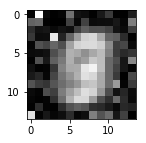

Epoch:  161  Loss:  755546.8103182737
Epoch:  162  Loss:  755570.3366268225
Epoch:  163  Loss:  755533.4090101138
Epoch:  164  Loss:  755588.0599579954
Epoch:  165  Loss:  755552.7834769549


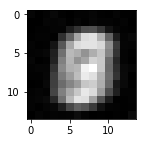

Epoch:  166  Loss:  755527.2875640927
Epoch:  167  Loss:  755480.9703730728
Epoch:  168  Loss:  755505.2868666773
Epoch:  169  Loss:  755525.0876313137
Epoch:  170  Loss:  755512.3945078909


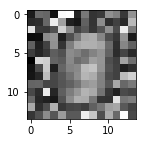

Epoch:  171  Loss:  755479.3078261192
Epoch:  172  Loss:  755493.6857401609
Epoch:  173  Loss:  755409.850059585
Epoch:  174  Loss:  755419.5487524155
Epoch:  175  Loss:  755423.0768894765


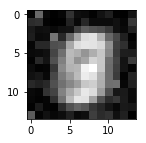

Epoch:  176  Loss:  755426.3786766566
Epoch:  177  Loss:  755473.2361424215
Epoch:  178  Loss:  755386.8272608578
Epoch:  179  Loss:  755456.0038920139
Epoch:  180  Loss:  755447.8460276723


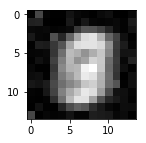

Epoch:  181  Loss:  755357.6582553134
Epoch:  182  Loss:  755346.7375530049
Epoch:  183  Loss:  755406.1551042381
Epoch:  184  Loss:  755367.3909416787
Epoch:  185  Loss:  755397.4887532298


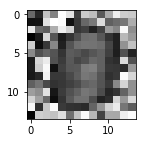

Epoch:  186  Loss:  755419.3987911151
Epoch:  187  Loss:  755397.3705459194
Epoch:  188  Loss:  755324.9448144515
Epoch:  189  Loss:  755358.3071716154
Epoch:  190  Loss:  755350.8287426002


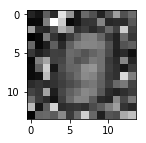

Epoch:  191  Loss:  755322.0282074382
Epoch:  192  Loss:  755379.6350860056
Epoch:  193  Loss:  755335.1908242985
Epoch:  194  Loss:  755337.4117874642
Epoch:  195  Loss:  755351.438742727


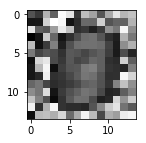

Epoch:  196  Loss:  755293.3377918961
Epoch:  197  Loss:  755301.6603116449
Epoch:  198  Loss:  755308.7679918827
Epoch:  199  Loss:  755285.0628780866
Epoch:  200  Loss:  755286.5175392088


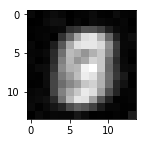

Epoch:  201  Loss:  755251.9407649479
Epoch:  202  Loss:  755252.3438347824
Epoch:  203  Loss:  755299.301120812
Epoch:  204  Loss:  755276.5444756473
Epoch:  205  Loss:  755263.0170996798


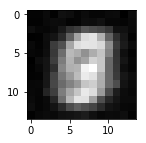

Epoch:  206  Loss:  755311.2203476955
Epoch:  207  Loss:  755272.9962528128
Epoch:  208  Loss:  755189.5189669222
Epoch:  209  Loss:  755242.7352380397
Epoch:  210  Loss:  755272.6493907223


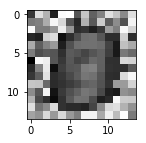

Epoch:  211  Loss:  755233.3288326098
Epoch:  212  Loss:  755303.999182445
Epoch:  213  Loss:  755275.4723041286
Epoch:  214  Loss:  755261.0368533276
Epoch:  215  Loss:  755270.5825234952


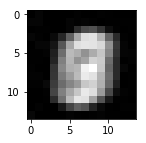

Epoch:  216  Loss:  755252.4017828532
Epoch:  217  Loss:  755273.3779952746
Epoch:  218  Loss:  755235.728387271
Epoch:  219  Loss:  755213.9002975147
Epoch:  220  Loss:  755233.3264274346


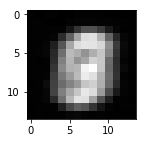

Epoch:  221  Loss:  755290.5800096594
Epoch:  222  Loss:  755187.0952397083
Epoch:  223  Loss:  755233.7280472658
Epoch:  224  Loss:  755221.1918877212
Epoch:  225  Loss:  755169.9434892362


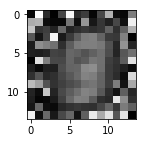

Epoch:  226  Loss:  755259.9514344411
Epoch:  227  Loss:  755243.8696757118
Epoch:  228  Loss:  755198.22178248
Epoch:  229  Loss:  755195.419350805
Epoch:  230  Loss:  755244.3923376754


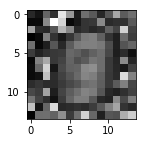

Epoch:  231  Loss:  755167.5644710407
Epoch:  232  Loss:  755169.5875867825
Epoch:  233  Loss:  755240.0396688047
Epoch:  234  Loss:  755205.0792197344
Epoch:  235  Loss:  755218.7100870172


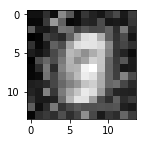

Epoch:  236  Loss:  755219.2381365078
Epoch:  237  Loss:  755212.6161156243
Epoch:  238  Loss:  755242.5764196042
Epoch:  239  Loss:  755236.9009774465
Epoch:  240  Loss:  755207.7278406358


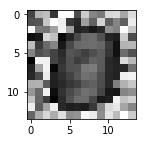

Epoch:  241  Loss:  755187.4497357877
Epoch:  242  Loss:  755216.695466544
Epoch:  243  Loss:  755214.2323669441
Epoch:  244  Loss:  755172.7365768409
Epoch:  245  Loss:  755193.5462703914


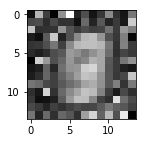

Epoch:  246  Loss:  755190.9898633594
Epoch:  247  Loss:  755220.480449995
Epoch:  248  Loss:  755211.4030242595
Epoch:  249  Loss:  755238.4829069411
Epoch:  250  Loss:  755192.9179284177


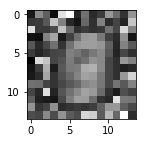

Epoch:  251  Loss:  755221.9224630699
Epoch:  252  Loss:  755205.2373458863
Epoch:  253  Loss:  755214.6916713312
Epoch:  254  Loss:  755280.7246058456
Epoch:  255  Loss:  755241.1593372879


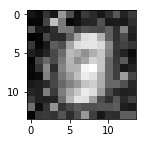

Epoch:  256  Loss:  755270.7651874961
Epoch:  257  Loss:  755266.6491654874
Epoch:  258  Loss:  755315.9899779331
Epoch:  259  Loss:  755277.9110824931
Epoch:  260  Loss:  755301.0496691288


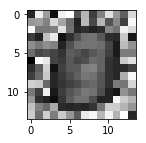

Epoch:  261  Loss:  755292.996362586
Epoch:  262  Loss:  755341.6406838072
Epoch:  263  Loss:  755301.007007228
Epoch:  264  Loss:  755334.6705741694
Epoch:  265  Loss:  755356.3669167736


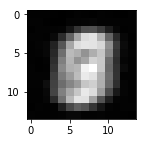

Epoch:  266  Loss:  755279.6373903039
Epoch:  267  Loss:  755310.3232324247
Epoch:  268  Loss:  755336.4717890667
Epoch:  269  Loss:  755346.0749122007
Epoch:  270  Loss:  755401.3327046813


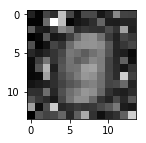

Epoch:  271  Loss:  755482.2093920623
Epoch:  272  Loss:  755373.218800203
Epoch:  273  Loss:  755345.9020448978
Epoch:  274  Loss:  755427.0980397776
Epoch:  275  Loss:  755354.9130765236


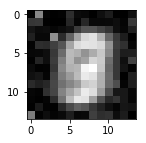

Epoch:  276  Loss:  755356.4202515521
Epoch:  277  Loss:  755358.0285261914
Epoch:  278  Loss:  755532.9939427563
Epoch:  279  Loss:  755390.2167285685
Epoch:  280  Loss:  755462.6095193038


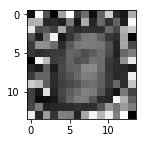

Epoch:  281  Loss:  755469.2974962408
Epoch:  282  Loss:  755546.1899545856
Epoch:  283  Loss:  755440.5657253686
Epoch:  284  Loss:  755513.452568467
Epoch:  285  Loss:  755611.8823144002


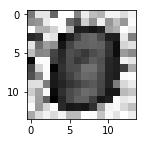

Epoch:  286  Loss:  755588.2934642575
Epoch:  287  Loss:  755646.2670282549
Epoch:  288  Loss:  755635.1251818713
Epoch:  289  Loss:  755640.4171842062
Epoch:  290  Loss:  755754.8973665632


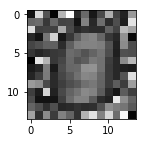

Epoch:  291  Loss:  755746.2864860205
Epoch:  292  Loss:  755766.5634637487
Epoch:  293  Loss:  755856.4606905836
Epoch:  294  Loss:  755854.6223926245
Epoch:  295  Loss:  755889.637831365


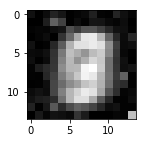

Epoch:  296  Loss:  756087.7579230721
Epoch:  297  Loss:  756018.9811908602
Epoch:  298  Loss:  756125.8208649774
Epoch:  299  Loss:  756241.1927929859
Epoch:  300  Loss:  756347.3473701971


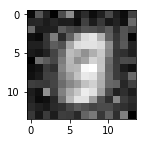

Epoch:  301  Loss:  756398.1312383302
Epoch:  302  Loss:  756196.0122547318
Epoch:  303  Loss:  756489.4360189314
Epoch:  304  Loss:  756570.8514261977
Epoch:  305  Loss:  756645.953829768


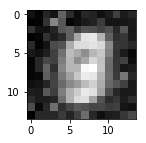

Epoch:  306  Loss:  756606.276185688
Epoch:  307  Loss:  756895.741096532
Epoch:  308  Loss:  756849.9988260893
Epoch:  309  Loss:  756955.849282372
Epoch:  310  Loss:  757043.7474136782


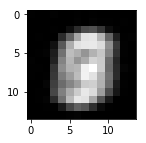

Epoch:  311  Loss:  757166.1056389058
Epoch:  312  Loss:  757371.5659846895
Epoch:  313  Loss:  757451.5484003299
Epoch:  314  Loss:  757469.3464613312
Epoch:  315  Loss:  757845.1275169968


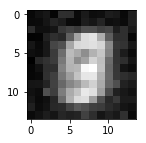

Epoch:  316  Loss:  758044.0597744264
Epoch:  317  Loss:  757972.8603513874
Epoch:  318  Loss:  758712.972665323
Epoch:  319  Loss:  759035.5159840117
Epoch:  320  Loss:  759700.0184700502


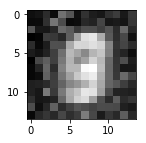

Epoch:  321  Loss:  759957.7992585892
Epoch:  322  Loss:  760420.2581746326
Epoch:  323  Loss:  761298.1476256121
Epoch:  324  Loss:  762074.5311974671
Epoch:  325  Loss:  763362.1209505532


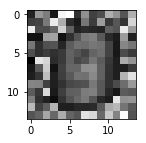

Epoch:  326  Loss:  764102.5652420501
Epoch:  327  Loss:  765693.1052082494
Epoch:  328  Loss:  767456.4916081271
Epoch:  329  Loss:  769382.0571688082
Epoch:  330  Loss:  772877.9192321579


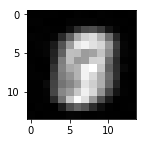

Epoch:  331  Loss:  777432.1959540509
Epoch:  332  Loss:  781905.9774604179
Epoch:  333  Loss:  785352.3161455444
Epoch:  334  Loss:  788485.2518116768
Epoch:  335  Loss:  790607.1250415886


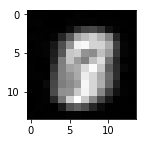

Epoch:  336  Loss:  791912.84661453
Epoch:  337  Loss:  791934.3462036606
Epoch:  338  Loss:  790749.4114767516
Epoch:  339  Loss:  788046.051251295
Epoch:  340  Loss:  784571.4460827089


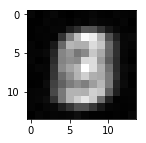

Epoch:  341  Loss:  780631.0030525448
Epoch:  342  Loss:  777159.1507828
Epoch:  343  Loss:  774545.4324200227
Epoch:  344  Loss:  771060.5033435357
Epoch:  345  Loss:  769191.8427547563


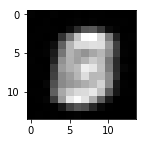

Epoch:  346  Loss:  766677.404663761
Epoch:  347  Loss:  764624.5806817024
Epoch:  348  Loss:  762775.6846723603
Epoch:  349  Loss:  761219.4537056047
Epoch:  350  Loss:  759186.1079207632


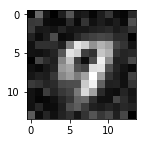

Epoch:  351  Loss:  757280.1431182283
Epoch:  352  Loss:  755816.2987483202
Epoch:  353  Loss:  754063.4090219706
Epoch:  354  Loss:  752158.8959409691
Epoch:  355  Loss:  750654.9114517777


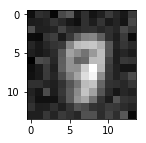

Epoch:  356  Loss:  748926.0704847518
Epoch:  357  Loss:  747463.8648478034
Epoch:  358  Loss:  745356.2250796714
Epoch:  359  Loss:  743984.6445645058
Epoch:  360  Loss:  742403.8710541291


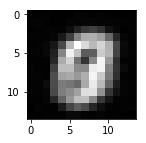

Epoch:  361  Loss:  740931.1626787274
Epoch:  362  Loss:  739867.0761262286
Epoch:  363  Loss:  737966.3086619887
Epoch:  364  Loss:  736872.4129867619
Epoch:  365  Loss:  735169.6581708884


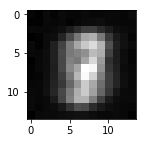

Epoch:  366  Loss:  734279.3824761637
Epoch:  367  Loss:  732380.7704797598
Epoch:  368  Loss:  731986.4240048315
Epoch:  369  Loss:  730635.0077557394
Epoch:  370  Loss:  729371.9649772778


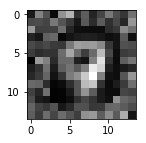

Epoch:  371  Loss:  728830.0558172377
Epoch:  372  Loss:  727639.92190788
Epoch:  373  Loss:  726995.9522822278
Epoch:  374  Loss:  726335.7312037583
Epoch:  375  Loss:  725448.4834531427


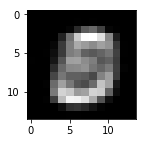

Epoch:  376  Loss:  724566.3664278155
Epoch:  377  Loss:  723525.1369712156
Epoch:  378  Loss:  723460.236896086
Epoch:  379  Loss:  722220.6352070839
Epoch:  380  Loss:  721939.8941880787


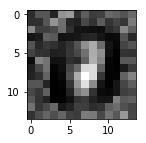

Epoch:  381  Loss:  720444.6095372734
Epoch:  382  Loss:  720671.8489718653
Epoch:  383  Loss:  719952.5601490323
Epoch:  384  Loss:  719685.1750188945
Epoch:  385  Loss:  718981.030798665


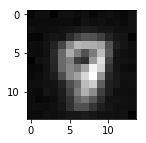

Epoch:  386  Loss:  718257.623772581
Epoch:  387  Loss:  717699.8187576309
Epoch:  388  Loss:  717926.4097525107
Epoch:  389  Loss:  716891.681553584
Epoch:  390  Loss:  716459.9465671079


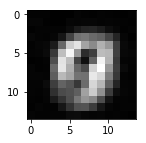

Epoch:  391  Loss:  716080.4423224452
Epoch:  392  Loss:  715701.455966816
Epoch:  393  Loss:  715610.7777411992
Epoch:  394  Loss:  714644.2179249851
Epoch:  395  Loss:  715008.5944344805


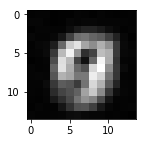

Epoch:  396  Loss:  714379.5762108185
Epoch:  397  Loss:  714231.8982374958
Epoch:  398  Loss:  713670.4283527329
Epoch:  399  Loss:  713072.0003746498
Epoch:  400  Loss:  712769.6544866625


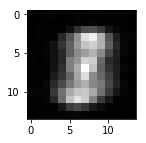

Epoch:  401  Loss:  712610.1783044225
Epoch:  402  Loss:  712443.5639183357
Epoch:  403  Loss:  711807.0097672086
Epoch:  404  Loss:  711420.0121130387
Epoch:  405  Loss:  711435.1244268597


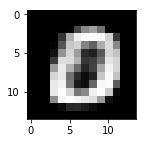

Epoch:  406  Loss:  711036.5061984266
Epoch:  407  Loss:  710772.3799814113
Epoch:  408  Loss:  710811.2449641274
Epoch:  409  Loss:  710419.2822069257
Epoch:  410  Loss:  710089.154648084


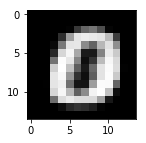

Epoch:  411  Loss:  709679.2359811891
Epoch:  412  Loss:  709429.0553266561
Epoch:  413  Loss:  709113.0537544325
Epoch:  414  Loss:  708992.2051471891
Epoch:  415  Loss:  708881.2569131053


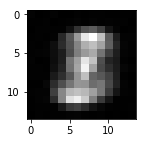

Epoch:  416  Loss:  708864.971706345
Epoch:  417  Loss:  708388.1930895678
Epoch:  418  Loss:  708138.7004119213
Epoch:  419  Loss:  707841.071776476
Epoch:  420  Loss:  707493.3668152986


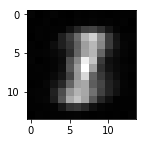

Epoch:  421  Loss:  707151.6452645416
Epoch:  422  Loss:  707075.0485954415
Epoch:  423  Loss:  706811.0432449942
Epoch:  424  Loss:  706570.6274702428
Epoch:  425  Loss:  706544.6775929234


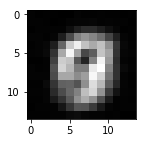

Epoch:  426  Loss:  706219.8931873193
Epoch:  427  Loss:  705980.2500117433
Epoch:  428  Loss:  705639.7514353564
Epoch:  429  Loss:  705320.377985007
Epoch:  430  Loss:  705541.0012666003


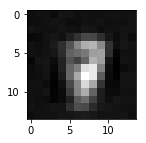

Epoch:  431  Loss:  705257.4326200592
Epoch:  432  Loss:  704852.5973581212
Epoch:  433  Loss:  704732.5948447944
Epoch:  434  Loss:  704547.1920935904
Epoch:  435  Loss:  704415.0466356132


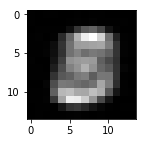

Epoch:  436  Loss:  704283.690719654
Epoch:  437  Loss:  704059.0660584838
Epoch:  438  Loss:  703872.9437159876
Epoch:  439  Loss:  703967.7418239503
Epoch:  440  Loss:  703806.3577862264


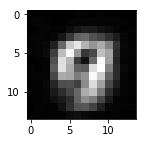

Epoch:  441  Loss:  702865.4179187425
Epoch:  442  Loss:  703338.6412339257
Epoch:  443  Loss:  702741.6794992177
Epoch:  444  Loss:  702819.2076077
Epoch:  445  Loss:  702722.6471875906


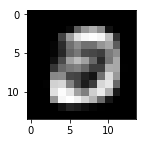

Epoch:  446  Loss:  702764.0103377225
Epoch:  447  Loss:  702124.0628366192
Epoch:  448  Loss:  702555.7086251545
Epoch:  449  Loss:  702084.2738378483
Epoch:  450  Loss:  701670.9581718459


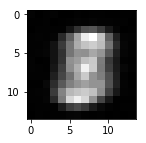

Epoch:  451  Loss:  702019.1383764817
Epoch:  452  Loss:  702000.7238970997
Epoch:  453  Loss:  701638.0799456077
Epoch:  454  Loss:  701541.1483714635
Epoch:  455  Loss:  701279.2299512837


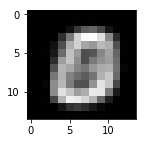

Epoch:  456  Loss:  701266.4537009854
Epoch:  457  Loss:  700897.3723219773
Epoch:  458  Loss:  700669.0809353058
Epoch:  459  Loss:  700816.7441537401
Epoch:  460  Loss:  700854.904579077


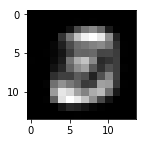

Epoch:  461  Loss:  700392.5167194664
Epoch:  462  Loss:  700683.1933971368
Epoch:  463  Loss:  700451.5361191106
Epoch:  464  Loss:  700458.7377273226
Epoch:  465  Loss:  700258.5148971947


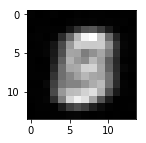

Epoch:  466  Loss:  700243.9628317185
Epoch:  467  Loss:  699943.2515566198
Epoch:  468  Loss:  699963.0759468721
Epoch:  469  Loss:  699772.6835436514
Epoch:  470  Loss:  699947.1876359975


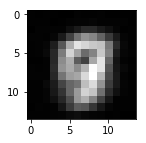

Epoch:  471  Loss:  699665.3521578859
Epoch:  472  Loss:  699235.1036315169
Epoch:  473  Loss:  699592.1210394456
Epoch:  474  Loss:  699409.7032207247
Epoch:  475  Loss:  699199.6473719281


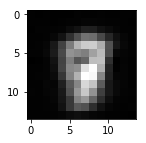

Epoch:  476  Loss:  699058.1216712391
Epoch:  477  Loss:  698660.3675182117
Epoch:  478  Loss:  699007.0661641448
Epoch:  479  Loss:  698893.3689397342
Epoch:  480  Loss:  698951.7188782266


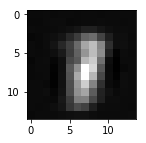

Epoch:  481  Loss:  698642.7987711154
Epoch:  482  Loss:  698639.0128389527
Epoch:  483  Loss:  698690.9029931512
Epoch:  484  Loss:  698644.5409270958
Epoch:  485  Loss:  698542.5853023392


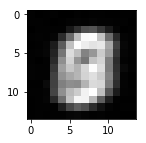

Epoch:  486  Loss:  698369.8576330384
Epoch:  487  Loss:  698222.5774236582
Epoch:  488  Loss:  698232.7310381786
Epoch:  489  Loss:  698415.9552557139
Epoch:  490  Loss:  698123.2678821383


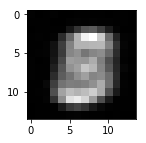

Epoch:  491  Loss:  697989.2341553584
Epoch:  492  Loss:  698324.0060677393
Epoch:  493  Loss:  697817.7963355001
Epoch:  494  Loss:  698142.332662336
Epoch:  495  Loss:  697650.1324371785


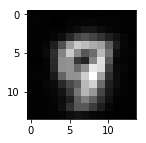

Epoch:  496  Loss:  697979.6244100451
Epoch:  497  Loss:  697638.0444019402
Epoch:  498  Loss:  698000.9237352973
Epoch:  499  Loss:  697977.1075601921
Epoch:  500  Loss:  697490.6826401528


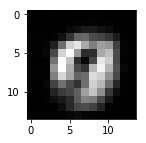

Epoch:  501  Loss:  697945.6303517001
Epoch:  502  Loss:  697500.1576228793
Epoch:  503  Loss:  697605.7723918977
Epoch:  504  Loss:  697631.2528288908
Epoch:  505  Loss:  697176.1792125482


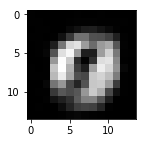

Epoch:  506  Loss:  697659.0701979459
Epoch:  507  Loss:  697575.6007259353
Epoch:  508  Loss:  697099.5827202564
Epoch:  509  Loss:  697281.8489295223
Epoch:  510  Loss:  697582.0618730334


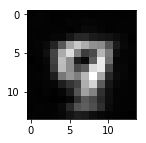

Epoch:  511  Loss:  697384.0859443343
Epoch:  512  Loss:  697272.4543282785
Epoch:  513  Loss:  697021.2458532384
Epoch:  514  Loss:  697310.679853424
Epoch:  515  Loss:  696839.080410962


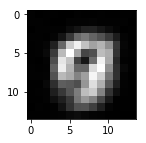

Epoch:  516  Loss:  697039.8292183264
Epoch:  517  Loss:  697195.882096437
Epoch:  518  Loss:  697211.7910292788
Epoch:  519  Loss:  696920.3863011795
Epoch:  520  Loss:  696958.0981849948


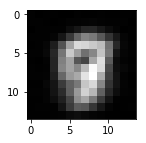

Epoch:  521  Loss:  696783.2743658836
Epoch:  522  Loss:  697060.0362715604
Epoch:  523  Loss:  697049.161351283
Epoch:  524  Loss:  697035.3331689636
Epoch:  525  Loss:  696856.1791819087


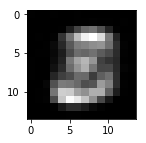

Epoch:  526  Loss:  696589.8849062645
Epoch:  527  Loss:  696313.9769414414
Epoch:  528  Loss:  696501.401950423
Epoch:  529  Loss:  696587.562339107
Epoch:  530  Loss:  696750.8462887116


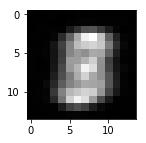

Epoch:  531  Loss:  696721.8391238812
Epoch:  532  Loss:  696915.0433277406
Epoch:  533  Loss:  696566.1672124433
Epoch:  534  Loss:  696876.9875514818
Epoch:  535  Loss:  696430.9298372053


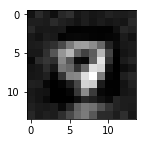

Epoch:  536  Loss:  696586.986881929
Epoch:  537  Loss:  696446.9987909727
Epoch:  538  Loss:  696744.1639280778
Epoch:  539  Loss:  696605.9640680653
Epoch:  540  Loss:  696558.9469724683


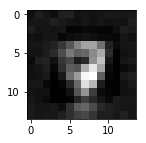

Epoch:  541  Loss:  696290.882465258
Epoch:  542  Loss:  696634.9699473574
Epoch:  543  Loss:  696201.6145738947
Epoch:  544  Loss:  696299.8493849179
Epoch:  545  Loss:  696399.3526252442


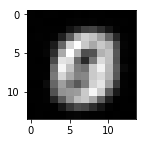

Epoch:  546  Loss:  696368.8926258943
Epoch:  547  Loss:  696334.650911377
Epoch:  548  Loss:  696470.1977235517
Epoch:  549  Loss:  696171.9782846406
Epoch:  550  Loss:  696249.7291175111


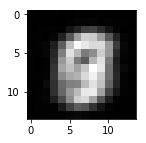

Epoch:  551  Loss:  696083.151531356
Epoch:  552  Loss:  696456.2073615906
Epoch:  553  Loss:  696282.2515647045
Epoch:  554  Loss:  696290.1911353362
Epoch:  555  Loss:  696100.920588791


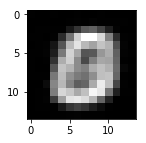

Epoch:  556  Loss:  696098.9264399435
Epoch:  557  Loss:  696541.7562964524
Epoch:  558  Loss:  695738.9583486476
Epoch:  559  Loss:  696055.4818745591
Epoch:  560  Loss:  696150.8660387482


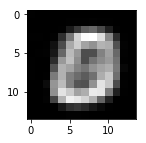

Epoch:  561  Loss:  696048.4553080082
Epoch:  562  Loss:  696525.1595385391
Epoch:  563  Loss:  695843.8995388619
Epoch:  564  Loss:  696092.1684096642
Epoch:  565  Loss:  696351.541989305


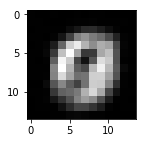

Epoch:  566  Loss:  696105.495463243
Epoch:  567  Loss:  696257.9108469896
Epoch:  568  Loss:  695772.8077422207
Epoch:  569  Loss:  696106.040022977
Epoch:  570  Loss:  696191.2226854305


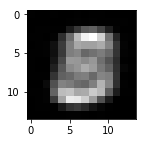

Epoch:  571  Loss:  695976.9843436163
Epoch:  572  Loss:  695784.2792645016
Epoch:  573  Loss:  696234.0390315676
Epoch:  574  Loss:  695856.4165979348
Epoch:  575  Loss:  696066.7189625152


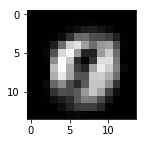

Epoch:  576  Loss:  695696.4917357102
Epoch:  577  Loss:  695818.5091102745
Epoch:  578  Loss:  696231.8607665488
Epoch:  579  Loss:  695905.6348699002
Epoch:  580  Loss:  696140.8546458669


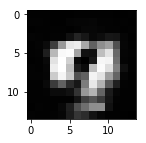

Epoch:  581  Loss:  695890.1089656668
Epoch:  582  Loss:  695801.861314383
Epoch:  583  Loss:  696014.6875037919
Epoch:  584  Loss:  695704.7599047417
Epoch:  585  Loss:  695748.4775843417


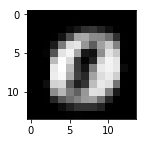

Epoch:  586  Loss:  696112.4998892545
Epoch:  587  Loss:  695742.2782884288
Epoch:  588  Loss:  696321.5592726453
Epoch:  589  Loss:  695561.2305733288
Epoch:  590  Loss:  696290.396645481


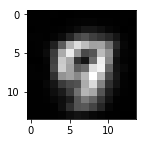

Epoch:  591  Loss:  695913.0914261093
Epoch:  592  Loss:  696059.8332540768
Epoch:  593  Loss:  696012.6142301406
Epoch:  594  Loss:  695843.9479393488
Epoch:  595  Loss:  695689.0317455239


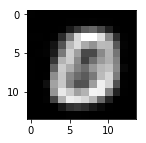

Epoch:  596  Loss:  695562.6433040512
Epoch:  597  Loss:  695674.0992307013
Epoch:  598  Loss:  695932.6946790579
Epoch:  599  Loss:  696105.1754792011
Epoch:  600  Loss:  695896.4003908348


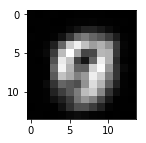

Done Training


In [6]:
vae1 = VAE(input_dim=196, latent_dim=2, learn_rate=1e-4)
vae1.train(x_train=x_train, epochs=600, batch_size=600, shuffle=True)

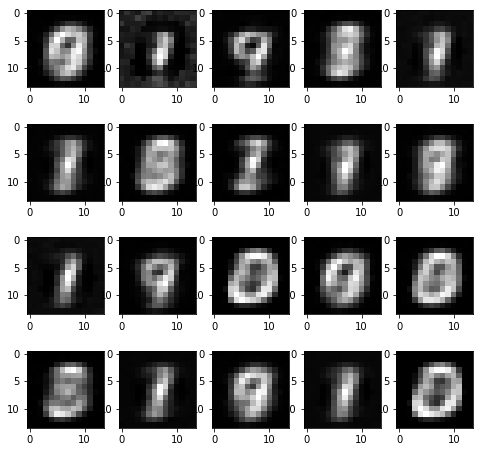

In [7]:
fig=plt.figure(figsize=(8, 8))

for i in range(1, 21):
    z = np.random.normal(0, 1, vae1.latent_dim)
    img = vae1.decoder(z).reshape((14,14))
    fig.add_subplot(4, 5, i)
    plt.imshow(img, cmap='gray')
plt.show()

Epoch:  1  Loss:  2790686.755867835
Epoch:  2  Loss:  1170005.749970634
Epoch:  3  Loss:  940175.6782916666
Epoch:  4  Loss:  865458.597467014
Epoch:  5  Loss:  843906.6060346158


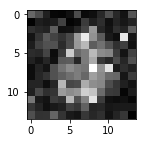

Epoch:  6  Loss:  832770.1002967643
Epoch:  7  Loss:  807677.1418371054
Epoch:  8  Loss:  768896.8760424057
Epoch:  9  Loss:  762227.4345013959
Epoch:  10  Loss:  757754.3813310197


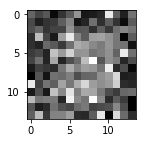

Epoch:  11  Loss:  753463.7783775373
Epoch:  12  Loss:  750480.56875631
Epoch:  13  Loss:  747753.7039970205
Epoch:  14  Loss:  744767.5171426538
Epoch:  15  Loss:  742780.3941438346


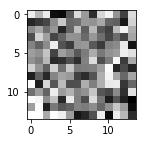

Epoch:  16  Loss:  740603.7806611906
Epoch:  17  Loss:  738965.0492196874
Epoch:  18  Loss:  737393.9854829708
Epoch:  19  Loss:  735716.315620468
Epoch:  20  Loss:  734377.1179611703


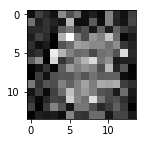

Epoch:  21  Loss:  733398.8531662279
Epoch:  22  Loss:  732509.7584858874
Epoch:  23  Loss:  731468.6902220385
Epoch:  24  Loss:  730608.1903864647
Epoch:  25  Loss:  729775.614108106


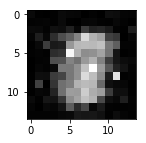

Epoch:  26  Loss:  729005.4190506038
Epoch:  27  Loss:  728565.9195254538
Epoch:  28  Loss:  727913.6538294378
Epoch:  29  Loss:  727545.5031938584
Epoch:  30  Loss:  726929.6919628294


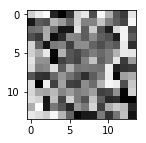

Epoch:  31  Loss:  726541.827439848
Epoch:  32  Loss:  726172.4060415562
Epoch:  33  Loss:  725545.1528003311
Epoch:  34  Loss:  725449.9192463353
Epoch:  35  Loss:  725117.6354272189


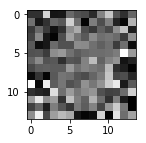

Epoch:  36  Loss:  724796.0061648221
Epoch:  37  Loss:  724334.8183428681
Epoch:  38  Loss:  724280.9027922576
Epoch:  39  Loss:  723949.3502716724
Epoch:  40  Loss:  723693.0830458094


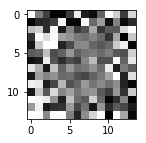

Epoch:  41  Loss:  723660.0071077617
Epoch:  42  Loss:  723315.2356872625
Epoch:  43  Loss:  723083.3437045674
Epoch:  44  Loss:  723226.2165294621
Epoch:  45  Loss:  723088.5418889609


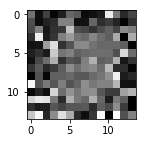

Epoch:  46  Loss:  722554.6379798538
Epoch:  47  Loss:  722500.8130337009
Epoch:  48  Loss:  722443.7729216325
Epoch:  49  Loss:  722323.6843824559
Epoch:  50  Loss:  722240.9848081539


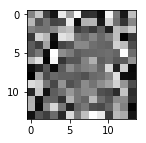

Epoch:  51  Loss:  721916.4059785756
Epoch:  52  Loss:  721847.737370839
Epoch:  53  Loss:  721778.2419307869
Epoch:  54  Loss:  721622.1394773781
Epoch:  55  Loss:  721537.8891266743


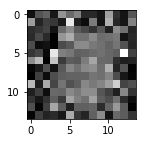

Epoch:  56  Loss:  721267.0818302161
Epoch:  57  Loss:  721367.470498738
Epoch:  58  Loss:  721226.2875486192
Epoch:  59  Loss:  721071.7908191368
Epoch:  60  Loss:  721017.797282505


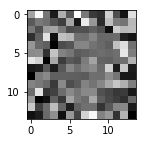

Epoch:  61  Loss:  720954.194335551
Epoch:  62  Loss:  720850.6183187113
Epoch:  63  Loss:  720793.6484927356
Epoch:  64  Loss:  720650.1582076947
Epoch:  65  Loss:  720442.5380202348


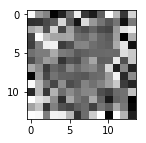

Epoch:  66  Loss:  720531.5438655062
Epoch:  67  Loss:  720554.4260838681
Epoch:  68  Loss:  720256.2518284922
Epoch:  69  Loss:  720456.8343160818
Epoch:  70  Loss:  720346.4778690616


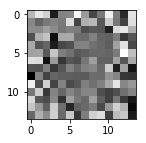

Epoch:  71  Loss:  720394.0052832029
Epoch:  72  Loss:  720063.0007388806
Epoch:  73  Loss:  720195.6781125695
Epoch:  74  Loss:  720120.2021577766
Epoch:  75  Loss:  719846.4094573848


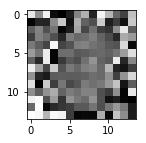

Epoch:  76  Loss:  719908.7731024072
Epoch:  77  Loss:  719883.2923330213
Epoch:  78  Loss:  719708.0982936496
Epoch:  79  Loss:  719752.9907880637
Epoch:  80  Loss:  719682.5606349232


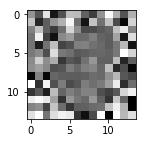

Epoch:  81  Loss:  719714.5757134324
Epoch:  82  Loss:  719540.550117007
Epoch:  83  Loss:  719721.8364794863
Epoch:  84  Loss:  719488.2132656419
Epoch:  85  Loss:  719356.3474120492


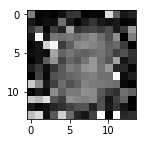

Epoch:  86  Loss:  719423.918237941
Epoch:  87  Loss:  719259.4391310198
Epoch:  88  Loss:  719359.0611211908
Epoch:  89  Loss:  719331.0710628718
Epoch:  90  Loss:  719217.4046186004


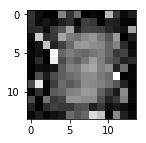

Epoch:  91  Loss:  719198.0585553242
Epoch:  92  Loss:  719185.3051043396
Epoch:  93  Loss:  719101.9527471066
Epoch:  94  Loss:  719015.4986899897
Epoch:  95  Loss:  719067.0870376161


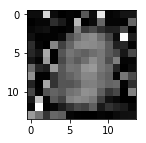

Epoch:  96  Loss:  718990.018219898
Epoch:  97  Loss:  718953.2512847474
Epoch:  98  Loss:  719007.3777653408
Epoch:  99  Loss:  718866.8367762944
Epoch:  100  Loss:  718897.9712092977


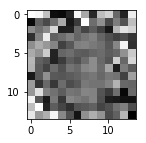

Epoch:  101  Loss:  718875.8101294286
Epoch:  102  Loss:  718760.8111361283
Epoch:  103  Loss:  718724.2349924346
Epoch:  104  Loss:  718678.1576067073
Epoch:  105  Loss:  718685.5287000992


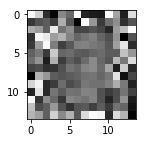

Epoch:  106  Loss:  718716.0387693201
Epoch:  107  Loss:  718517.1703734722
Epoch:  108  Loss:  718565.9819260072
Epoch:  109  Loss:  718610.4053275939
Epoch:  110  Loss:  718489.2209030853


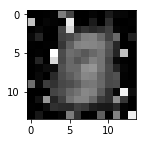

Epoch:  111  Loss:  718548.5864711367
Epoch:  112  Loss:  718484.9417070901
Epoch:  113  Loss:  718432.8525563829
Epoch:  114  Loss:  718512.8291277448
Epoch:  115  Loss:  718424.1755240732


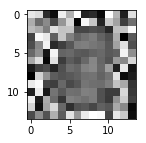

Epoch:  116  Loss:  718381.1722941003
Epoch:  117  Loss:  718394.2718394136
Epoch:  118  Loss:  718427.3499495946
Epoch:  119  Loss:  718416.0754199951
Epoch:  120  Loss:  718349.6448098066


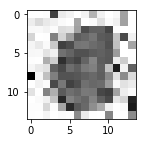

Epoch:  121  Loss:  718236.7105557633
Epoch:  122  Loss:  718279.0295824367
Epoch:  123  Loss:  718249.9810054618
Epoch:  124  Loss:  718228.343810098
Epoch:  125  Loss:  718163.2078716451


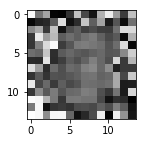

Epoch:  126  Loss:  718158.3564414621
Epoch:  127  Loss:  718234.1419991195
Epoch:  128  Loss:  718335.260949538
Epoch:  129  Loss:  718145.81228752
Epoch:  130  Loss:  718144.2922774899


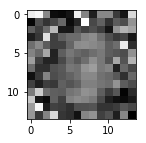

Epoch:  131  Loss:  718068.4652864811
Epoch:  132  Loss:  718109.8273548416
Epoch:  133  Loss:  718029.6581562376
Epoch:  134  Loss:  718070.4731393713
Epoch:  135  Loss:  717974.6510799876


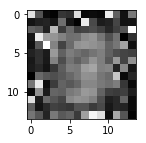

Epoch:  136  Loss:  718034.2731832769
Epoch:  137  Loss:  718035.4670104793
Epoch:  138  Loss:  718025.6688792111
Epoch:  139  Loss:  717899.4031276659
Epoch:  140  Loss:  717883.1100452493


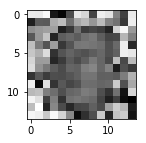

Epoch:  141  Loss:  718050.2605879629
Epoch:  142  Loss:  717967.5328995603
Epoch:  143  Loss:  718113.1363898249
Epoch:  144  Loss:  718154.4822397307
Epoch:  145  Loss:  717912.2918717632


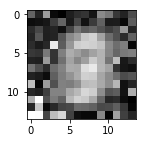

Epoch:  146  Loss:  717981.9574574261
Epoch:  147  Loss:  717965.167387518
Epoch:  148  Loss:  717962.3373450689
Epoch:  149  Loss:  717965.2383488001
Epoch:  150  Loss:  718067.5227285787


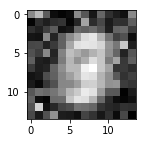

Epoch:  151  Loss:  717995.6535288264
Epoch:  152  Loss:  718032.9396774468
Epoch:  153  Loss:  718195.7611632687
Epoch:  154  Loss:  718252.1408434067
Epoch:  155  Loss:  718241.9210887318


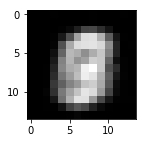

Epoch:  156  Loss:  718531.4590959699
Epoch:  157  Loss:  718638.2505236847
Epoch:  158  Loss:  718959.9081520046
Epoch:  159  Loss:  719472.0056273447
Epoch:  160  Loss:  719886.8527155629


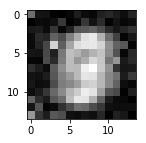

Epoch:  161  Loss:  720582.8756998857
Epoch:  162  Loss:  721822.2439690237
Epoch:  163  Loss:  723321.5027134559
Epoch:  164  Loss:  724949.1487217466
Epoch:  165  Loss:  726453.0553872396


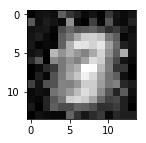

Epoch:  166  Loss:  727652.978594215
Epoch:  167  Loss:  729230.012115181
Epoch:  168  Loss:  729920.8632252268
Epoch:  169  Loss:  730185.9700356356
Epoch:  170  Loss:  729632.3229206898


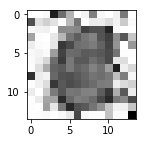

Epoch:  171  Loss:  726857.1465938828
Epoch:  172  Loss:  722076.4270798897
Epoch:  173  Loss:  714355.7548511338
Epoch:  174  Loss:  705942.226806181
Epoch:  175  Loss:  699238.6112256973


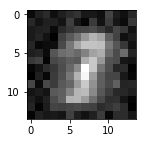

Epoch:  176  Loss:  693587.2451234148
Epoch:  177  Loss:  688981.8101371032
Epoch:  178  Loss:  685121.7028122481
Epoch:  179  Loss:  682183.4519320956
Epoch:  180  Loss:  679335.3064926075


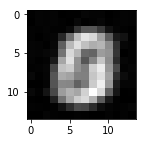

Epoch:  181  Loss:  677766.4282836602
Epoch:  182  Loss:  675404.576536496
Epoch:  183  Loss:  674158.8002932133
Epoch:  184  Loss:  672619.9971966567
Epoch:  185  Loss:  671949.9974174557


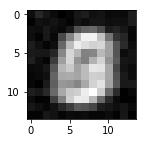

Epoch:  186  Loss:  670709.6554422999
Epoch:  187  Loss:  670405.1593578411
Epoch:  188  Loss:  669665.2189944992
Epoch:  189  Loss:  669050.507248727
Epoch:  190  Loss:  668369.9510927097


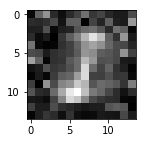

Epoch:  191  Loss:  668162.2318686129
Epoch:  192  Loss:  668044.7634667333
Epoch:  193  Loss:  667702.0225633889
Epoch:  194  Loss:  667454.7570558983
Epoch:  195  Loss:  667694.9041391952


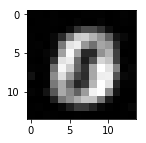

Epoch:  196  Loss:  667841.3020173833
Epoch:  197  Loss:  667501.3404868304
Epoch:  198  Loss:  668073.3725017007
Epoch:  199  Loss:  668254.5127733506
Epoch:  200  Loss:  668415.0669222865


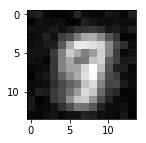

Epoch:  201  Loss:  669255.2089992232


/home/aravind/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


Epoch:  202  Loss:  669963.5769446075
Epoch:  203  Loss:  671053.0929568477
Epoch:  204  Loss:  671894.4600997291
Epoch:  205  Loss:  672815.6271602135


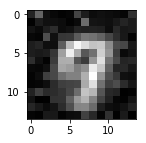

Epoch:  206  Loss:  673778.0152698783
Epoch:  207  Loss:  674908.0897982446
Epoch:  208  Loss:  675775.083456764
Epoch:  209  Loss:  676856.6286438069
Epoch:  210  Loss:  677557.0786923905


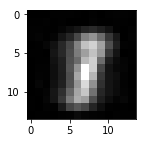

Epoch:  211  Loss:  678331.2547270833
Epoch:  212  Loss:  678419.7590230406
Epoch:  213  Loss:  678146.4640003563
Epoch:  214  Loss:  678359.374524724
Epoch:  215  Loss:  677673.7969541015


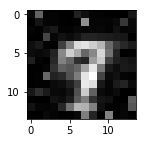

Epoch:  216  Loss:  677130.5522206341
Epoch:  217  Loss:  676063.4650641341
Epoch:  218  Loss:  674394.8147639566
Epoch:  219  Loss:  673573.5885752802
Epoch:  220  Loss:  672169.4801820035


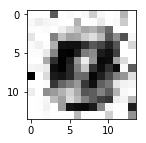

Epoch:  221  Loss:  670942.7506545809
Epoch:  222  Loss:  669105.0602870593
Epoch:  223  Loss:  667824.7813486921
Epoch:  224  Loss:  666426.3447870758
Epoch:  225  Loss:  664637.4849101043


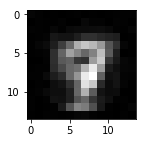

Epoch:  226  Loss:  663283.891927175
Epoch:  227  Loss:  661454.8808620126
Epoch:  228  Loss:  659703.3462893777
Epoch:  229  Loss:  658758.3214522083
Epoch:  230  Loss:  657490.8882925855


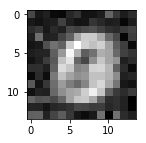

Epoch:  231  Loss:  656277.8164354666
Epoch:  232  Loss:  656058.1013035899
Epoch:  233  Loss:  656138.2264008304
Epoch:  234  Loss:  655821.7313150802
Epoch:  235  Loss:  656628.034931071


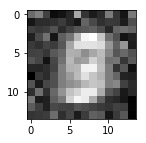

Epoch:  236  Loss:  657433.438677278
Epoch:  237  Loss:  658542.7179176338
Epoch:  238  Loss:  659807.8411895212
Epoch:  239  Loss:  661373.7757517209
Epoch:  240  Loss:  663186.3942128479


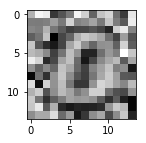

Epoch:  241  Loss:  664834.134714013
Epoch:  242  Loss:  666492.413714691
Epoch:  243  Loss:  667924.5109390869
Epoch:  244  Loss:  669274.7300559641
Epoch:  245  Loss:  670150.7360475836


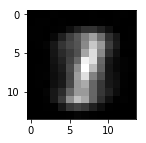

Epoch:  246  Loss:  670619.8072662448
Epoch:  247  Loss:  671002.591493289
Epoch:  248  Loss:  670820.6853581032
Epoch:  249  Loss:  671156.0287603169
Epoch:  250  Loss:  671009.1160511358


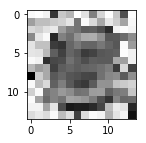

Epoch:  251  Loss:  671015.034682513
Epoch:  252  Loss:  670229.0553533745
Epoch:  253  Loss:  669722.0256770148
Epoch:  254  Loss:  669122.1789449393
Epoch:  255  Loss:  668126.8933388388


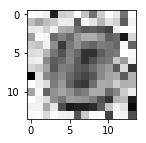

Epoch:  256  Loss:  667427.2506786666
Epoch:  257  Loss:  666591.573802849
Epoch:  258  Loss:  665447.190347774
Epoch:  259  Loss:  664229.5320026744
Epoch:  260  Loss:  663425.8009853357


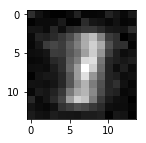

Epoch:  261  Loss:  662209.0312851348
Epoch:  262  Loss:  661505.0414374757
Epoch:  263  Loss:  660499.0265888327
Epoch:  264  Loss:  659870.1738641292
Epoch:  265  Loss:  659192.252321876


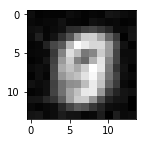

Epoch:  266  Loss:  658467.8774812282
Epoch:  267  Loss:  657645.5214174642
Epoch:  268  Loss:  656773.8781451677
Epoch:  269  Loss:  656561.530843353
Epoch:  270  Loss:  655739.4070978692


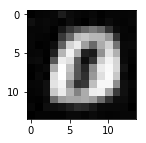

Epoch:  271  Loss:  655533.408442175
Epoch:  272  Loss:  654965.9692409261
Epoch:  273  Loss:  654852.6577662377
Epoch:  274  Loss:  654369.9829631686
Epoch:  275  Loss:  654128.9225289614


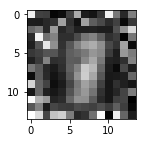

Epoch:  276  Loss:  654595.5544508763
Epoch:  277  Loss:  654008.2299869326
Epoch:  278  Loss:  653562.3853217692
Epoch:  279  Loss:  653631.7679622988
Epoch:  280  Loss:  653897.0315806846


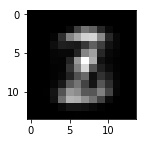

Epoch:  281  Loss:  653821.7889088579
Epoch:  282  Loss:  654150.5285015262
Epoch:  283  Loss:  655002.7450853304
Epoch:  284  Loss:  655411.7067018481
Epoch:  285  Loss:  656340.1627064646


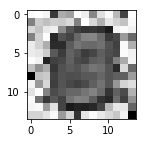

Epoch:  286  Loss:  656630.2321549219
Epoch:  287  Loss:  656900.19040731
Epoch:  288  Loss:  658798.3022774581
Epoch:  289  Loss:  659292.0342966499
Epoch:  290  Loss:  660569.2598333413


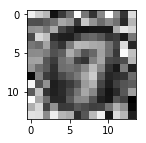

Epoch:  291  Loss:  662162.1566367339
Epoch:  292  Loss:  662706.4716594497
Epoch:  293  Loss:  663850.2662995593
Epoch:  294  Loss:  664838.6148407033
Epoch:  295  Loss:  666402.1877639423


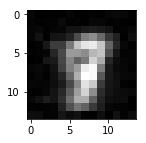

Epoch:  296  Loss:  667692.5010067858
Epoch:  297  Loss:  668333.7443323337
Epoch:  298  Loss:  669024.2966019644
Epoch:  299  Loss:  670885.9784354818
Epoch:  300  Loss:  671952.0391738347


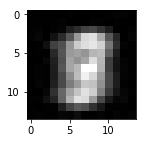

Epoch:  301  Loss:  671950.7560835498
Epoch:  302  Loss:  672688.8986739978
Epoch:  303  Loss:  673402.5550168635
Epoch:  304  Loss:  673428.9751958926
Epoch:  305  Loss:  673776.3515776697


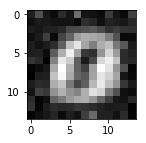

Epoch:  306  Loss:  673443.6391637769
Epoch:  307  Loss:  673428.5995173687
Epoch:  308  Loss:  673297.6043862596
Epoch:  309  Loss:  673071.8914680168
Epoch:  310  Loss:  672591.6261921229


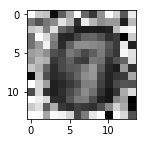

Epoch:  311  Loss:  673354.5262837472
Epoch:  312  Loss:  672593.3914142497
Epoch:  313  Loss:  672746.9069315218
Epoch:  314  Loss:  673067.0377372128
Epoch:  315  Loss:  673257.5469941362


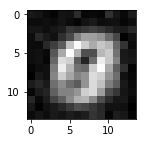

Epoch:  316  Loss:  672529.0389937611
Epoch:  317  Loss:  673091.254162046
Epoch:  318  Loss:  673497.9115758062
Epoch:  319  Loss:  673557.0782161641
Epoch:  320  Loss:  673489.8944105853


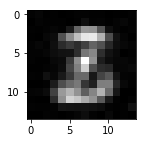

Epoch:  321  Loss:  673610.4664932273
Epoch:  322  Loss:  673828.1357800121
Epoch:  323  Loss:  673984.9447668099
Epoch:  324  Loss:  673854.8611394167
Epoch:  325  Loss:  673511.6956336824


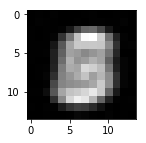

Epoch:  326  Loss:  672610.4329290284
Epoch:  327  Loss:  672448.1815201408
Epoch:  328  Loss:  671867.2081680923
Epoch:  329  Loss:  670959.9693412825
Epoch:  330  Loss:  670144.1083185954


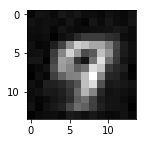

Epoch:  331  Loss:  669165.7585882964
Epoch:  332  Loss:  668585.1648479343
Epoch:  333  Loss:  667684.8881822908
Epoch:  334  Loss:  667092.4985542468
Epoch:  335  Loss:  665906.1060992967


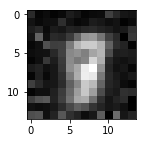

Epoch:  336  Loss:  665146.8681586103
Epoch:  337  Loss:  664384.4814056876
Epoch:  338  Loss:  664360.1807847625
Epoch:  339  Loss:  662589.5745278822
Epoch:  340  Loss:  662017.6825620633


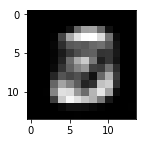

Epoch:  341  Loss:  661785.2601932988
Epoch:  342  Loss:  660612.0785537605
Epoch:  343  Loss:  659659.7109624773
Epoch:  344  Loss:  659336.7068318841
Epoch:  345  Loss:  658437.3493801206


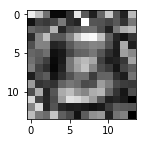

Epoch:  346  Loss:  657695.9459521236
Epoch:  347  Loss:  656087.4406617294
Epoch:  348  Loss:  655293.392300073
Epoch:  349  Loss:  654941.271715441
Epoch:  350  Loss:  653733.7298240786


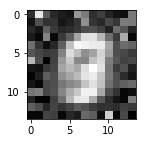

Epoch:  351  Loss:  653076.3010210393
Epoch:  352  Loss:  652585.8392017272
Epoch:  353  Loss:  651390.1691410685
Epoch:  354  Loss:  650486.4757090693
Epoch:  355  Loss:  649093.8926724386


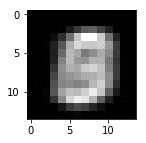

Epoch:  356  Loss:  648911.0723092092
Epoch:  357  Loss:  647590.0072775205
Epoch:  358  Loss:  647626.3772657793
Epoch:  359  Loss:  646623.943716461
Epoch:  360  Loss:  645907.9127632934


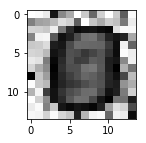

Epoch:  361  Loss:  645600.6479874158
Epoch:  362  Loss:  645021.0304303926
Epoch:  363  Loss:  644717.1607484285
Epoch:  364  Loss:  644254.2529085339
Epoch:  365  Loss:  643290.6895334576


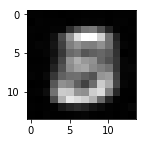

Epoch:  366  Loss:  643440.9484194813
Epoch:  367  Loss:  642665.3191215519
Epoch:  368  Loss:  642432.8444202051
Epoch:  369  Loss:  642092.0070600794
Epoch:  370  Loss:  642132.6334144002


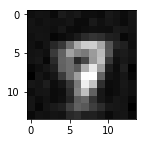

Epoch:  371  Loss:  641929.7233751367
Epoch:  372  Loss:  642097.2375028868
Epoch:  373  Loss:  640856.8190213863
Epoch:  374  Loss:  640745.9724886817
Epoch:  375  Loss:  640321.9167106107


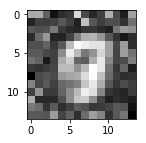

Epoch:  376  Loss:  641057.3655721791
Epoch:  377  Loss:  640584.9201192053
Epoch:  378  Loss:  640581.3157996439
Epoch:  379  Loss:  640330.1693876934
Epoch:  380  Loss:  640709.416956347


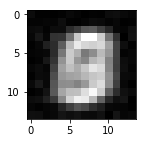

Epoch:  381  Loss:  639323.7848084433
Epoch:  382  Loss:  640498.7303627315
Epoch:  383  Loss:  638859.4720928116
Epoch:  384  Loss:  639498.8856123072
Epoch:  385  Loss:  639029.2747171995


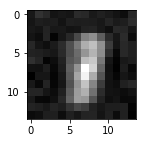

Epoch:  386  Loss:  638755.9875794295
Epoch:  387  Loss:  638989.4975224745
Epoch:  388  Loss:  639008.0654309385
Epoch:  389  Loss:  639483.1077341193
Epoch:  390  Loss:  638349.0240914184


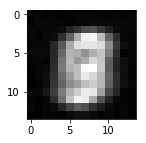

Epoch:  391  Loss:  638422.8618313896
Epoch:  392  Loss:  638662.0988044178
Epoch:  393  Loss:  638663.5884389806
Epoch:  394  Loss:  638716.6989173499
Epoch:  395  Loss:  638556.8546963541


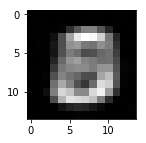

Epoch:  396  Loss:  639043.9486605432
Epoch:  397  Loss:  638164.5040968931
Epoch:  398  Loss:  638419.7083522229
Epoch:  399  Loss:  639150.1021213615
Epoch:  400  Loss:  638165.7797604233


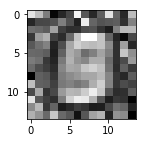

Epoch:  401  Loss:  638527.7585042448
Epoch:  402  Loss:  638601.9157255207
Epoch:  403  Loss:  639010.7794001587
Epoch:  404  Loss:  638833.2055372788
Epoch:  405  Loss:  638363.5347573353


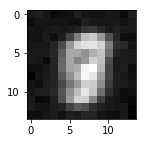

Epoch:  406  Loss:  639011.4588086489
Epoch:  407  Loss:  639366.2836063972
Epoch:  408  Loss:  639321.6660628408
Epoch:  409  Loss:  639891.0067530283
Epoch:  410  Loss:  639821.3456963822


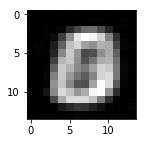

Epoch:  411  Loss:  639940.6217490208
Epoch:  412  Loss:  640386.8595526057
Epoch:  413  Loss:  639769.3047444702
Epoch:  414  Loss:  639660.0933357679
Epoch:  415  Loss:  640453.3742316931


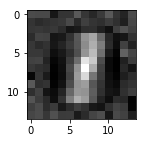

Epoch:  416  Loss:  640830.8726866195
Epoch:  417  Loss:  640546.6662205027
Epoch:  418  Loss:  640490.6769339113
Epoch:  419  Loss:  640863.4375040743
Epoch:  420  Loss:  640335.1366137029


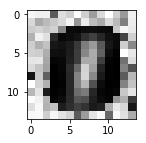

Epoch:  421  Loss:  639516.4748349836
Epoch:  422  Loss:  639943.5930268294
Epoch:  423  Loss:  639642.4795783669
Epoch:  424  Loss:  639205.3648865835
Epoch:  425  Loss:  639229.9534352064


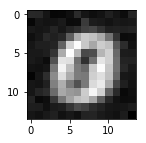

Epoch:  426  Loss:  639065.8035189044
Epoch:  427  Loss:  638366.1004877049
Epoch:  428  Loss:  638212.6371584225
Epoch:  429  Loss:  638798.3171025041
Epoch:  430  Loss:  637456.6499175829


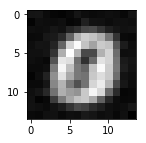

Epoch:  431  Loss:  637843.4927013214
Epoch:  432  Loss:  636859.982982213
Epoch:  433  Loss:  636867.6809290678
Epoch:  434  Loss:  636317.6566521048
Epoch:  435  Loss:  636494.639866412


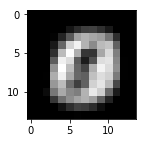

Epoch:  436  Loss:  635555.220819408
Epoch:  437  Loss:  635554.0273238115
Epoch:  438  Loss:  635079.4306342158
Epoch:  439  Loss:  634800.5555114279
Epoch:  440  Loss:  634450.85598986


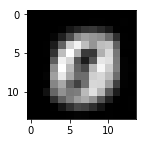

Epoch:  441  Loss:  634568.6830697524
Epoch:  442  Loss:  634245.3323320817
Epoch:  443  Loss:  634123.3089771958
Epoch:  444  Loss:  633397.1984990475
Epoch:  445  Loss:  633308.3780113981


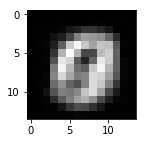

Epoch:  446  Loss:  633281.9334506094
Epoch:  447  Loss:  632949.365705425
Epoch:  448  Loss:  632861.5166932651
Epoch:  449  Loss:  632596.4302767658
Epoch:  450  Loss:  632016.6728617124


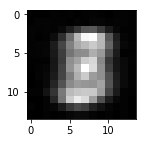

Epoch:  451  Loss:  632292.2553280711
Epoch:  452  Loss:  632317.1405153114
Epoch:  453  Loss:  631427.0924924578
Epoch:  454  Loss:  631774.5331405213
Epoch:  455  Loss:  631222.2665240142


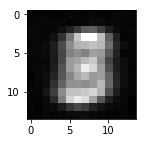

Epoch:  456  Loss:  631121.1926515572
Epoch:  457  Loss:  631228.4851610953
Epoch:  458  Loss:  631326.7837185749
Epoch:  459  Loss:  630903.3325655258
Epoch:  460  Loss:  631077.8914959992


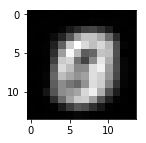

Epoch:  461  Loss:  630838.9431031083
Epoch:  462  Loss:  630631.4967690693
Epoch:  463  Loss:  630718.457139361
Epoch:  464  Loss:  630966.1746362208
Epoch:  465  Loss:  630234.0910566575


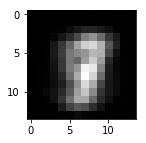

Epoch:  466  Loss:  630385.0847720172
Epoch:  467  Loss:  630431.9878556152
Epoch:  468  Loss:  630163.7222975076
Epoch:  469  Loss:  630578.2042029253
Epoch:  470  Loss:  630297.3057692689


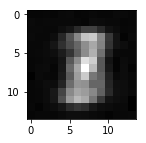

Epoch:  471  Loss:  630445.4026216122
Epoch:  472  Loss:  630381.1314061759
Epoch:  473  Loss:  630278.943466066
Epoch:  474  Loss:  630200.3202689321
Epoch:  475  Loss:  630475.8007681728


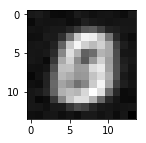

Epoch:  476  Loss:  630280.1786644035
Epoch:  477  Loss:  630612.915147174
Epoch:  478  Loss:  630582.7368368432
Epoch:  479  Loss:  630773.8881576144
Epoch:  480  Loss:  630571.7140256168


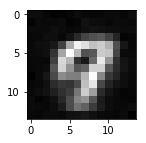

Epoch:  481  Loss:  630973.2258708711
Epoch:  482  Loss:  630868.0559870417
Epoch:  483  Loss:  630906.2574008034
Epoch:  484  Loss:  631033.765172948
Epoch:  485  Loss:  631314.0568211216


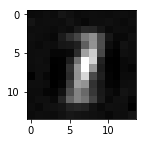

Epoch:  486  Loss:  631081.9233850873
Epoch:  487  Loss:  631417.7779495623
Epoch:  488  Loss:  631732.4148442347
Epoch:  489  Loss:  631772.6249828129
Epoch:  490  Loss:  631753.3357024763


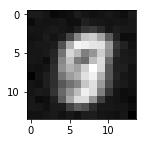

Epoch:  491  Loss:  632182.432275111
Epoch:  492  Loss:  632384.9587118267
Epoch:  493  Loss:  632156.78012729
Epoch:  494  Loss:  632725.2680487492
Epoch:  495  Loss:  633265.9422207623


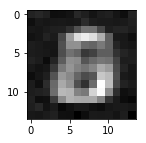

Epoch:  496  Loss:  633085.6064514205
Epoch:  497  Loss:  633122.0069509574
Epoch:  498  Loss:  633219.7328326592
Epoch:  499  Loss:  633910.9077466392
Epoch:  500  Loss:  633986.1510572914


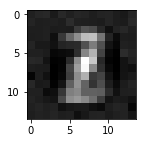

Done Training


In [24]:
vae2 = VAE(input_dim=196, latent_dim=4, learn_rate=1e-4)

vae2.train(x_train=x_train, epochs=500, batch_size=600, shuffle=True)

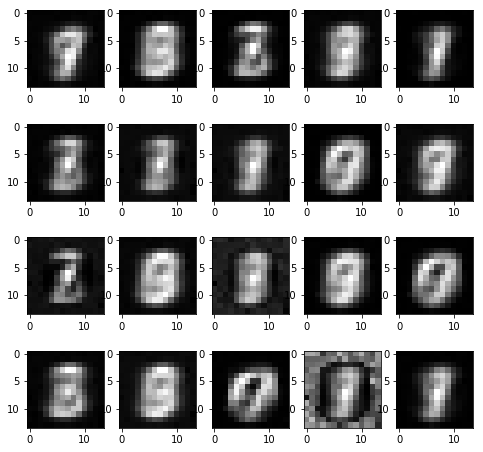

In [25]:
fig=plt.figure(figsize=(8, 8))

for i in range(1, 21):
    z = np.random.normal(0, 1, vae2.latent_dim)
    img = vae2.decoder(z).reshape((14,14))
    fig.add_subplot(4, 5, i)
    plt.imshow(img, cmap='gray')
plt.show()

Epoch:  1  Loss:  1505701.102979031
Epoch:  2  Loss:  872352.310090646
Epoch:  3  Loss:  771311.7566394855
Epoch:  4  Loss:  704287.0441088958
Epoch:  5  Loss:  668118.6333725218


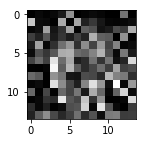

Epoch:  6  Loss:  633196.2623478184
Epoch:  7  Loss:  586715.6203103232
Epoch:  8  Loss:  571848.620021938
Epoch:  9  Loss:  579801.0241531461
Epoch:  10  Loss:  612853.330249055


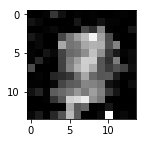

Epoch:  11  Loss:  615862.9860615307
Epoch:  12  Loss:  609768.9623695624
Epoch:  13  Loss:  604892.9932686961
Epoch:  14  Loss:  602020.7827784647
Epoch:  15  Loss:  597596.3651303512


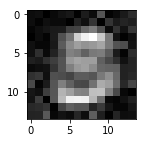

Epoch:  16  Loss:  595443.2487743628
Epoch:  17  Loss:  593763.7526942687
Epoch:  18  Loss:  590288.9998019229
Epoch:  19  Loss:  587869.29572972
Epoch:  20  Loss:  586124.9107547677


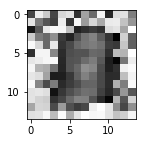

Epoch:  21  Loss:  581887.09650308
Epoch:  22  Loss:  577809.982179398
Epoch:  23  Loss:  578012.2760908115
Epoch:  24  Loss:  572072.2579054848
Epoch:  25  Loss:  572506.5783963449


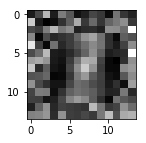

Epoch:  26  Loss:  575204.5189848545
Epoch:  27  Loss:  599481.8663690931
Epoch:  28  Loss:  592429.9800766781
Epoch:  29  Loss:  588387.4249279374
Epoch:  30  Loss:  603518.3666629377


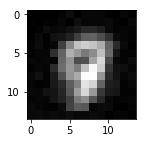

Epoch:  31  Loss:  616062.5720973674
Epoch:  32  Loss:  615674.2106602476
Epoch:  33  Loss:  616483.364809135
Epoch:  34  Loss:  618775.0573404948
Epoch:  35  Loss:  620680.4600303868


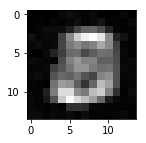

Epoch:  36  Loss:  616014.7495229872
Epoch:  37  Loss:  611929.85793297
Epoch:  38  Loss:  615148.2194184207
Epoch:  39  Loss:  614686.6336960545
Epoch:  40  Loss:  612402.365868685


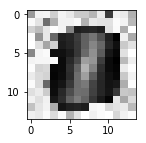

Epoch:  41  Loss:  610110.0292146272
Epoch:  42  Loss:  607314.3999200992
Epoch:  43  Loss:  604654.6223450382
Epoch:  44  Loss:  600841.0532357718
Epoch:  45  Loss:  598163.9631514162


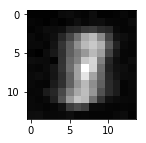

Epoch:  46  Loss:  596656.900052213
Epoch:  47  Loss:  596806.466035109
Epoch:  48  Loss:  595551.6789482707
Epoch:  49  Loss:  597446.5367039071
Epoch:  50  Loss:  596761.8695775351


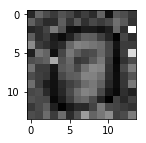

Epoch:  51  Loss:  598615.1942478709
Epoch:  52  Loss:  598181.5236579268
Epoch:  53  Loss:  598136.2430626332
Epoch:  54  Loss:  597456.6761678946
Epoch:  55  Loss:  596062.2618576898


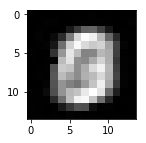

Epoch:  56  Loss:  595273.7587183102
Epoch:  57  Loss:  593577.2385519136
Epoch:  58  Loss:  592785.5483101254
Epoch:  59  Loss:  592491.8149340497
Epoch:  60  Loss:  591781.6200572798


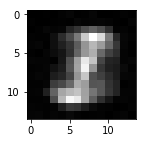

Epoch:  61  Loss:  590844.7142917023
Epoch:  62  Loss:  587899.8853839108
Epoch:  63  Loss:  585001.2571149389
Epoch:  64  Loss:  583252.3867763175
Epoch:  65  Loss:  581821.0192816075


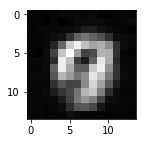

Epoch:  66  Loss:  581123.2501511597
Epoch:  67  Loss:  580751.5317540872
Epoch:  68  Loss:  580394.4930726297
Epoch:  69  Loss:  581092.3855606184
Epoch:  70  Loss:  581485.77149882


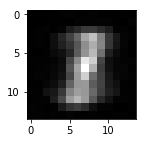

Epoch:  71  Loss:  581161.7737326025
Epoch:  72  Loss:  581700.6959290155
Epoch:  73  Loss:  582382.8110937205
Epoch:  74  Loss:  582329.5782394639
Epoch:  75  Loss:  582750.5910171733


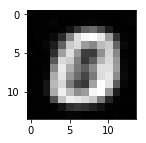

Epoch:  76  Loss:  582511.8926613864
Epoch:  77  Loss:  582223.792336663
Epoch:  78  Loss:  582105.174664161
Epoch:  79  Loss:  581931.0251629993
Epoch:  80  Loss:  581620.3771844271


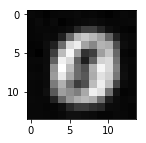

Epoch:  81  Loss:  580790.1366583054
Epoch:  82  Loss:  580284.4537351361
Epoch:  83  Loss:  579961.3856646492
Epoch:  84  Loss:  579991.1967720168
Epoch:  85  Loss:  580101.3395538367


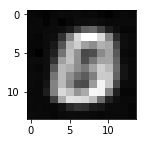

Epoch:  86  Loss:  580596.9320215697
Epoch:  87  Loss:  580502.9579735993
Epoch:  88  Loss:  581021.8315521803
Epoch:  89  Loss:  582178.2035155057
Epoch:  90  Loss:  582758.2584402227


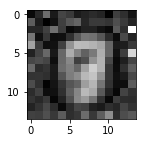

Epoch:  91  Loss:  583968.5406583527
Epoch:  92  Loss:  585561.0340748501
Epoch:  93  Loss:  586841.8083218226
Epoch:  94  Loss:  588206.2607393222
Epoch:  95  Loss:  589672.6391619873


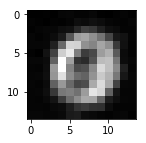

Epoch:  96  Loss:  591197.5636940539
Epoch:  97  Loss:  593013.1306154664
Epoch:  98  Loss:  594305.0896133347
Epoch:  99  Loss:  595564.6016067276
Epoch:  100  Loss:  596499.8676050415


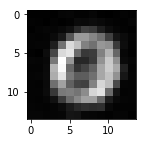

Epoch:  101  Loss:  598093.4374384363
Epoch:  102  Loss:  598740.9595974018
Epoch:  103  Loss:  599783.8107507288
Epoch:  104  Loss:  599943.1714021551
Epoch:  105  Loss:  600203.5930677028


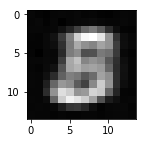

Epoch:  106  Loss:  600557.7889979037
Epoch:  107  Loss:  600907.5908641147
Epoch:  108  Loss:  601460.7082899981
Epoch:  109  Loss:  601059.6127606281
Epoch:  110  Loss:  601047.7668452435


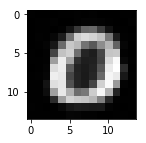

Epoch:  111  Loss:  601313.2704306613
Epoch:  112  Loss:  601113.5442519354
Epoch:  113  Loss:  601124.2668916843
Epoch:  114  Loss:  600988.206756791
Epoch:  115  Loss:  600906.3252374217


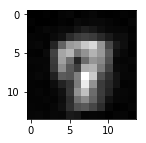

Epoch:  116  Loss:  601098.6404201165
Epoch:  117  Loss:  600574.0959977723


/home/aravind/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


Epoch:  118  Loss:  601131.4396732838
Epoch:  119  Loss:  600511.7157636771
Epoch:  120  Loss:  600893.3958640398


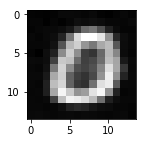

Epoch:  121  Loss:  600571.7297388434
Epoch:  122  Loss:  600232.9063833889
Epoch:  123  Loss:  601284.8287920288
Epoch:  124  Loss:  600674.127765009
Epoch:  125  Loss:  600328.040239303


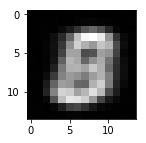

Epoch:  126  Loss:  600393.1770501966
Epoch:  127  Loss:  600291.0740898175
Epoch:  128  Loss:  599547.0240297414
Epoch:  129  Loss:  599339.2445894524
Epoch:  130  Loss:  598868.4856778209


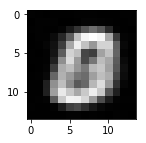

Epoch:  131  Loss:  597940.1388278981
Epoch:  132  Loss:  595814.5851529483
Epoch:  133  Loss:  593847.7613956432
Epoch:  134  Loss:  592830.5861413231
Epoch:  135  Loss:  591085.5154343084


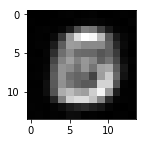

Epoch:  136  Loss:  590164.850287385
Epoch:  137  Loss:  590174.9315115693
Epoch:  138  Loss:  589332.0438196508
Epoch:  139  Loss:  589340.142685053
Epoch:  140  Loss:  589620.4100335564


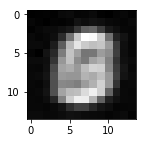

Epoch:  141  Loss:  589899.0024706887
Epoch:  142  Loss:  590201.9241574348
Epoch:  143  Loss:  590312.6370218244
Epoch:  144  Loss:  591050.5092612024
Epoch:  145  Loss:  592029.8140936361


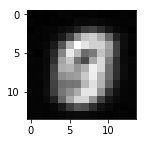

Epoch:  146  Loss:  592134.0408689823
Epoch:  147  Loss:  592134.7846107443
Epoch:  148  Loss:  592457.4963168424
Epoch:  149  Loss:  593102.5139255628
Epoch:  150  Loss:  592836.8324498988


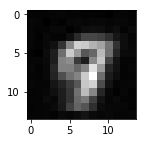

Epoch:  151  Loss:  592331.4321534453
Epoch:  152  Loss:  591600.1976219951
Epoch:  153  Loss:  591438.7086848118
Epoch:  154  Loss:  591386.2704703619
Epoch:  155  Loss:  590377.4907588247


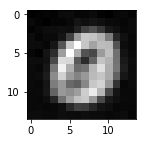

Epoch:  156  Loss:  589907.2577033774
Epoch:  157  Loss:  589462.4113028097
Epoch:  158  Loss:  588897.5837952726
Epoch:  159  Loss:  588539.4762805068
Epoch:  160  Loss:  587966.3399818469


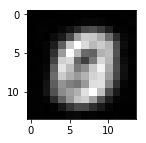

Epoch:  161  Loss:  587639.2028283091
Epoch:  162  Loss:  587405.0702801297
Epoch:  163  Loss:  586421.7515082594
Epoch:  164  Loss:  586071.4199444327
Epoch:  165  Loss:  584997.8970862521


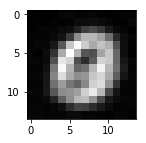

Epoch:  166  Loss:  584913.8694021603
Epoch:  167  Loss:  584685.6220799712
Epoch:  168  Loss:  584195.4229100887
Epoch:  169  Loss:  583308.9167642305
Epoch:  170  Loss:  583069.2365040687


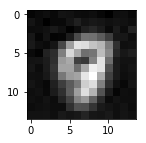

Epoch:  171  Loss:  582665.517832558
Epoch:  172  Loss:  582013.4021164816
Epoch:  173  Loss:  582103.3764307955
Epoch:  174  Loss:  582088.4686916998
Epoch:  175  Loss:  581077.3306473203


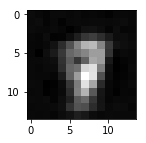

Epoch:  176  Loss:  581073.6858768093
Epoch:  177  Loss:  581102.4143068357
Epoch:  178  Loss:  581346.1839877721
Epoch:  179  Loss:  581502.0743974545
Epoch:  180  Loss:  581695.8265869992


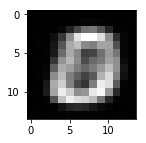

Epoch:  181  Loss:  581974.4565120944
Epoch:  182  Loss:  582134.7761422253
Epoch:  183  Loss:  582112.4417750939
Epoch:  184  Loss:  583427.1882157825
Epoch:  185  Loss:  583676.2144643413


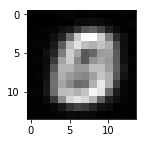

Epoch:  186  Loss:  583761.0915184704
Epoch:  187  Loss:  584337.8686769105
Epoch:  188  Loss:  584905.5575050104
Epoch:  189  Loss:  585187.7827858805
Epoch:  190  Loss:  585990.5307006442


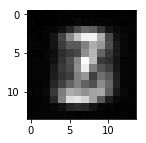

Epoch:  191  Loss:  586716.8670769754
Epoch:  192  Loss:  587107.1219998107
Epoch:  193  Loss:  588355.7829600866
Epoch:  194  Loss:  588476.2845720837
Epoch:  195  Loss:  589101.3707532919


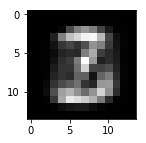

Epoch:  196  Loss:  589761.5137220027
Epoch:  197  Loss:  591205.1384427798
Epoch:  198  Loss:  591490.434689411
Epoch:  199  Loss:  591814.9587808121
Epoch:  200  Loss:  593309.2263757201


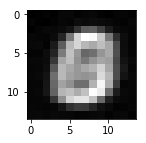

Done Training


In [19]:
vae3 = VAE(input_dim=196, latent_dim=10, learn_rate=5e-4)
vae3.train(x_train=x_train, epochs=200, batch_size=300, shuffle=True)

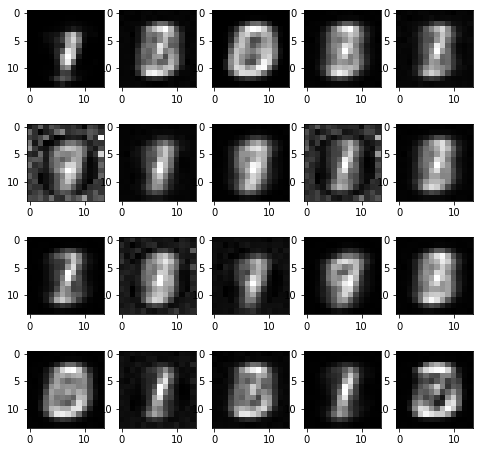

In [20]:
fig=plt.figure(figsize=(8, 8))

for i in range(1, 21):
    z = np.random.normal(0, 1, vae3.latent_dim)
    img = vae3.decoder(z).reshape((14,14))
    fig.add_subplot(4, 5, i)
    plt.imshow(img, cmap='gray')
plt.show()

Epoch:  1  Loss:  1315727.3064118566
Epoch:  2  Loss:  778199.1169915964
Epoch:  3  Loss:  759198.7405747873
Epoch:  4  Loss:  751951.9174203428
Epoch:  5  Loss:  748039.0787020384


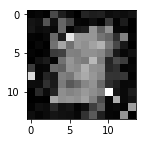

Epoch:  6  Loss:  745704.0840459735
Epoch:  7  Loss:  743719.7289411756
Epoch:  8  Loss:  742229.0604968136
Epoch:  9  Loss:  741328.9413605332
Epoch:  10  Loss:  740504.960665339


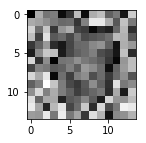

Epoch:  11  Loss:  739958.7674247791
Epoch:  12  Loss:  739582.6625629204
Epoch:  13  Loss:  739088.6482636769
Epoch:  14  Loss:  738857.6708991221
Epoch:  15  Loss:  738503.5418250227


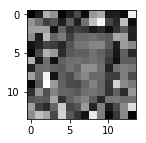

Epoch:  16  Loss:  738238.1191352631
Epoch:  17  Loss:  738053.7007967299
Epoch:  18  Loss:  737877.9356143859
Epoch:  19  Loss:  737646.6197790948
Epoch:  20  Loss:  737551.5297802688


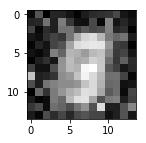

Epoch:  21  Loss:  737465.9404037613
Epoch:  22  Loss:  737304.0364839378
Epoch:  23  Loss:  737196.7316084888
Epoch:  24  Loss:  737200.2663366107
Epoch:  25  Loss:  737123.2258524534


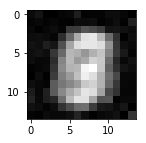

Epoch:  26  Loss:  736974.1098478461
Epoch:  27  Loss:  736930.154425892
Epoch:  28  Loss:  736864.7345191034
Epoch:  29  Loss:  736848.0950067423
Epoch:  30  Loss:  736828.2627167023


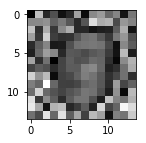

Epoch:  31  Loss:  736822.355606249
Epoch:  32  Loss:  736984.4488951623
Epoch:  33  Loss:  737081.036187195
Epoch:  34  Loss:  737131.8729819028
Epoch:  35  Loss:  737364.4959709551


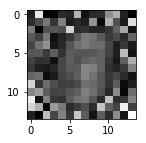

Epoch:  36  Loss:  737494.0529554536
Epoch:  37  Loss:  737580.3574431005
Epoch:  38  Loss:  737730.1476564873
Epoch:  39  Loss:  737906.9794168666
Epoch:  40  Loss:  738293.8413281163


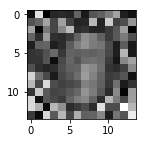

Epoch:  41  Loss:  738619.5356006162
Epoch:  42  Loss:  738495.270210155
Epoch:  43  Loss:  735128.7290245466
Epoch:  44  Loss:  729937.3399620032
Epoch:  45  Loss:  721811.5837151799


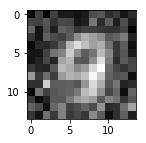

Epoch:  46  Loss:  708388.8261510914
Epoch:  47  Loss:  698112.492249364
Epoch:  48  Loss:  691858.278443769
Epoch:  49  Loss:  689654.1489019651
Epoch:  50  Loss:  689113.2511510911


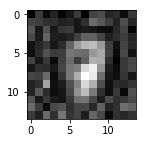

Epoch:  51  Loss:  690546.8971900445
Epoch:  52  Loss:  693109.7226402772
Epoch:  53  Loss:  692350.8754995561
Epoch:  54  Loss:  688227.1428520483
Epoch:  55  Loss:  682058.1055442765


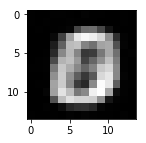

Epoch:  56  Loss:  677930.0504575114
Epoch:  57  Loss:  675867.3104331732
Epoch:  58  Loss:  675563.1817827369
Epoch:  59  Loss:  676527.7356682324
Epoch:  60  Loss:  677835.8414722871


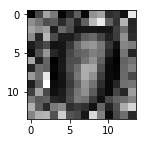

Epoch:  61  Loss:  677174.616324858
Epoch:  62  Loss:  678042.537796693
Epoch:  63  Loss:  676774.4782956499
Epoch:  64  Loss:  675393.4892068532
Epoch:  65  Loss:  675031.5696156946


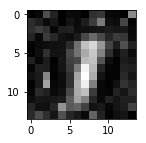

Epoch:  66  Loss:  677279.5011432376
Epoch:  67  Loss:  680522.1937032931
Epoch:  68  Loss:  684856.130729765
Epoch:  69  Loss:  689254.818738195
Epoch:  70  Loss:  694315.0018393217


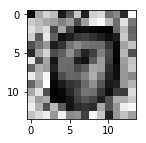

Epoch:  71  Loss:  697877.7924832298
Epoch:  72  Loss:  701210.3959927647
Epoch:  73  Loss:  702236.5308365236
Epoch:  74  Loss:  699585.3690583749
Epoch:  75  Loss:  692015.4159580664


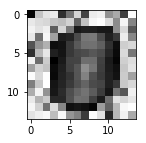

Epoch:  76  Loss:  683186.9096010663
Epoch:  77  Loss:  676963.2531197555
Epoch:  78  Loss:  672989.0777138671
Epoch:  79  Loss:  671112.6173095662
Epoch:  80  Loss:  668814.6981974768


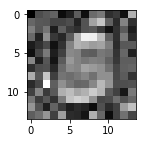

Epoch:  81  Loss:  667772.5634793745
Epoch:  82  Loss:  667042.3400416516
Epoch:  83  Loss:  666557.7465939153
Epoch:  84  Loss:  666065.2144570905
Epoch:  85  Loss:  666140.728738314


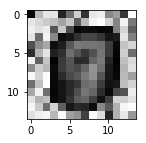

Epoch:  86  Loss:  665979.0587709504
Epoch:  87  Loss:  666130.597436378
Epoch:  88  Loss:  666400.9201769318
Epoch:  89  Loss:  666408.9618133027
Epoch:  90  Loss:  666699.5628160745


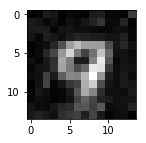

Epoch:  91  Loss:  666847.3349851215
Epoch:  92  Loss:  667375.2204536763
Epoch:  93  Loss:  667675.2099062023
Epoch:  94  Loss:  668174.9308999239
Epoch:  95  Loss:  668933.3104524402


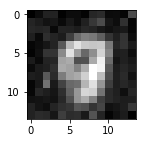

Epoch:  96  Loss:  669449.0822523448
Epoch:  97  Loss:  671075.3604586838
Epoch:  98  Loss:  671394.4677811586
Epoch:  99  Loss:  672892.6307645907
Epoch:  100  Loss:  673301.0148805851


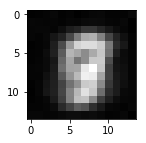

Epoch:  101  Loss:  675152.6682405914
Epoch:  102  Loss:  675930.6500392252
Epoch:  103  Loss:  677035.4194291605
Epoch:  104  Loss:  677588.6395151144
Epoch:  105  Loss:  679479.9149441187


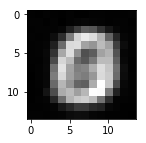

Epoch:  106  Loss:  679936.4735093319
Epoch:  107  Loss:  680361.0274714543
Epoch:  108  Loss:  681830.0007732754
Epoch:  109  Loss:  682201.4071149738
Epoch:  110  Loss:  682687.6304520816


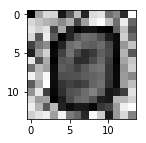

Epoch:  111  Loss:  683138.0331641671
Epoch:  112  Loss:  683866.7014861938
Epoch:  113  Loss:  684920.3894784445
Epoch:  114  Loss:  685272.4236009137
Epoch:  115  Loss:  685313.1401037385


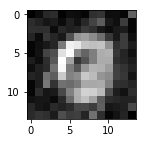

Epoch:  116  Loss:  685393.8824081606
Epoch:  117  Loss:  685039.3931398429
Epoch:  118  Loss:  685244.8806232833
Epoch:  119  Loss:  685277.3287397196
Epoch:  120  Loss:  684750.380192696


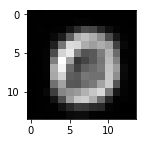

Epoch:  121  Loss:  684880.8192862454
Epoch:  122  Loss:  684582.6995870905
Epoch:  123  Loss:  685007.7081867944
Epoch:  124  Loss:  684581.8093342351
Epoch:  125  Loss:  685238.7670130752


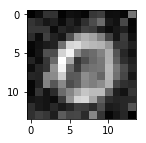

Epoch:  126  Loss:  684430.5597772278
Epoch:  127  Loss:  684238.2540531101
Epoch:  128  Loss:  684254.522888271
Epoch:  129  Loss:  684325.9993240155
Epoch:  130  Loss:  685178.8123601062


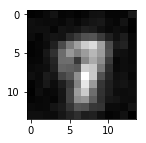

Epoch:  131  Loss:  684565.5985378098
Epoch:  132  Loss:  685299.710258782
Epoch:  133  Loss:  684187.2255455357
Epoch:  134  Loss:  683928.384747051
Epoch:  135  Loss:  683533.9529739583


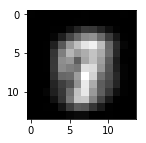

Epoch:  136  Loss:  684768.2069926044
Epoch:  137  Loss:  684628.7663365031


/home/aravind/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


Epoch:  138  Loss:  684620.8793025903
Epoch:  139  Loss:  684790.6145053696
Epoch:  140  Loss:  684423.7095717276


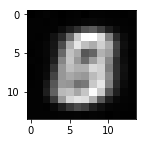

Epoch:  141  Loss:  684189.8231246243
Epoch:  142  Loss:  683769.4509929841
Epoch:  143  Loss:  684250.3785689381
Epoch:  144  Loss:  681922.5087283874
Epoch:  145  Loss:  679633.0566749957


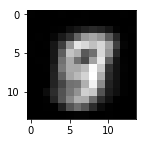

Epoch:  146  Loss:  677936.4722338003
Epoch:  147  Loss:  676873.3260886021
Epoch:  148  Loss:  674093.008180298
Epoch:  149  Loss:  673307.2640011539
Epoch:  150  Loss:  673534.3025824376


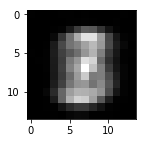

Epoch:  151  Loss:  672600.9293728016
Epoch:  152  Loss:  672916.699080275
Epoch:  153  Loss:  672445.911284237
Epoch:  154  Loss:  673461.5726248013
Epoch:  155  Loss:  673338.9167929351


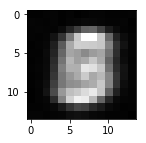

Epoch:  156  Loss:  674558.3548672638
Epoch:  157  Loss:  674673.4893070116
Epoch:  158  Loss:  674523.9548035753
Epoch:  159  Loss:  674783.632462345
Epoch:  160  Loss:  675003.3480992919


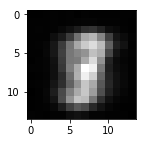

Epoch:  161  Loss:  675093.4115822521
Epoch:  162  Loss:  675295.5054140221
Epoch:  163  Loss:  675052.527130375
Epoch:  164  Loss:  675699.0149755932
Epoch:  165  Loss:  674917.7126891655


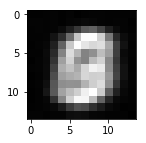

Epoch:  166  Loss:  673568.0835633448
Epoch:  167  Loss:  673045.1382414063
Epoch:  168  Loss:  672031.7098219524
Epoch:  169  Loss:  671022.5819482384
Epoch:  170  Loss:  668311.3722061199


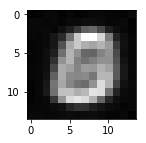

Epoch:  171  Loss:  667322.0413931163
Epoch:  172  Loss:  665214.9574193321
Epoch:  173  Loss:  663886.5135405457
Epoch:  174  Loss:  661151.5440112296
Epoch:  175  Loss:  659648.5705779432


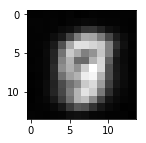

Epoch:  176  Loss:  658756.1045186148
Epoch:  177  Loss:  657704.2945678346
Epoch:  178  Loss:  657022.9949419295
Epoch:  179  Loss:  656818.2484465529
Epoch:  180  Loss:  656519.4604097281


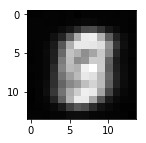

Epoch:  181  Loss:  655903.5396829132
Epoch:  182  Loss:  655211.4421531793
Epoch:  183  Loss:  654681.6795491558
Epoch:  184  Loss:  654356.0219553448
Epoch:  185  Loss:  654117.0840889934


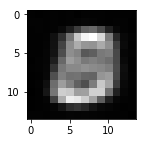

Epoch:  186  Loss:  652760.0110058575
Epoch:  187  Loss:  652889.7443574722
Epoch:  188  Loss:  652488.1359807958
Epoch:  189  Loss:  651964.5081265754
Epoch:  190  Loss:  651682.6932385206


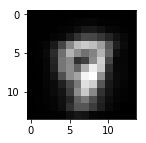

Epoch:  191  Loss:  651142.3330520722
Epoch:  192  Loss:  650929.9542594635
Epoch:  193  Loss:  650507.0588943289
Epoch:  194  Loss:  651112.6105341841
Epoch:  195  Loss:  649969.1849551969


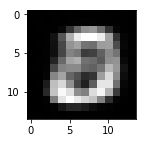

Epoch:  196  Loss:  650491.9368454693
Epoch:  197  Loss:  649992.0138298401
Epoch:  198  Loss:  650656.8391888613
Epoch:  199  Loss:  650385.0511075892
Epoch:  200  Loss:  650580.9774795143


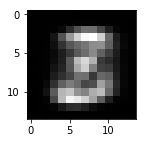

Epoch:  201  Loss:  650979.1672817394
Epoch:  202  Loss:  650775.8277286999
Epoch:  203  Loss:  651383.7275449575
Epoch:  204  Loss:  651182.5680992645
Epoch:  205  Loss:  651340.563713118


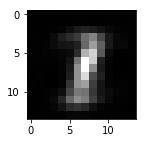

Epoch:  206  Loss:  652368.7350274236
Epoch:  207  Loss:  651855.6265651521
Epoch:  208  Loss:  652652.3972412889
Epoch:  209  Loss:  653003.4828998769
Epoch:  210  Loss:  653515.1464937491


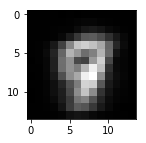

Epoch:  211  Loss:  654076.8585860314
Epoch:  212  Loss:  654307.26102753
Epoch:  213  Loss:  654927.523821492
Epoch:  214  Loss:  654875.6042451788
Epoch:  215  Loss:  655093.3728092406


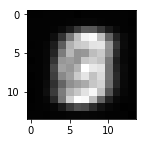

Epoch:  216  Loss:  655981.2737629878
Epoch:  217  Loss:  656162.1993744409
Epoch:  218  Loss:  656357.5129121243
Epoch:  219  Loss:  657378.3875588485
Epoch:  220  Loss:  657786.1828391304


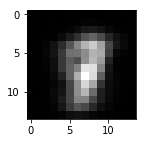

Epoch:  221  Loss:  657745.0268614516
Epoch:  222  Loss:  658497.3857280457
Epoch:  223  Loss:  659884.0199591937
Epoch:  224  Loss:  659231.9558859876
Epoch:  225  Loss:  658011.773103568


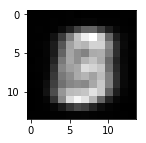

Epoch:  226  Loss:  656214.6767269213
Epoch:  227  Loss:  654120.9365337612
Epoch:  228  Loss:  653124.5568563448
Epoch:  229  Loss:  652978.8353236227
Epoch:  230  Loss:  652086.6198154964


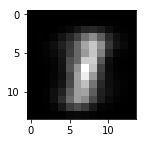

Epoch:  231  Loss:  652073.1813614991
Epoch:  232  Loss:  652204.8898702867
Epoch:  233  Loss:  651829.8655388275
Epoch:  234  Loss:  651368.7064841937
Epoch:  235  Loss:  651690.9149437984


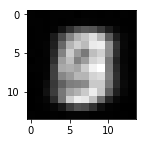

Epoch:  236  Loss:  651684.5265117718
Epoch:  237  Loss:  651760.7179337412
Epoch:  238  Loss:  651253.2349152851
Epoch:  239  Loss:  651096.5076040248
Epoch:  240  Loss:  651389.2084813432


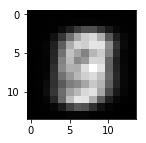

Epoch:  241  Loss:  651132.5968125134
Epoch:  242  Loss:  650695.1356806073
Epoch:  243  Loss:  651045.0606076942
Epoch:  244  Loss:  651332.9949868661
Epoch:  245  Loss:  650809.617193992


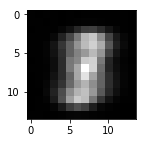

Epoch:  246  Loss:  651114.337687182
Epoch:  247  Loss:  650754.5753670183
Epoch:  248  Loss:  650849.3350450081
Epoch:  249  Loss:  650545.5589942209
Epoch:  250  Loss:  650825.5424882658


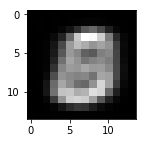

Epoch:  251  Loss:  651002.9189338794
Epoch:  252  Loss:  650807.1847934535
Epoch:  253  Loss:  651064.9253441173
Epoch:  254  Loss:  650941.7226564992
Epoch:  255  Loss:  650719.3486804907


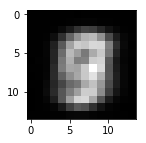

Epoch:  256  Loss:  650803.7215398772
Epoch:  257  Loss:  650857.724304647
Epoch:  258  Loss:  650658.5015295297
Epoch:  259  Loss:  651126.833115553
Epoch:  260  Loss:  651003.4009874259


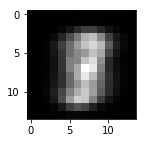

Epoch:  261  Loss:  650913.0460701959
Epoch:  262  Loss:  650804.1929571523
Epoch:  263  Loss:  650385.1743403808
Epoch:  264  Loss:  651166.2481032674
Epoch:  265  Loss:  650777.5978681993


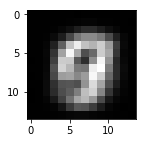

Epoch:  266  Loss:  651331.7788786152
Epoch:  267  Loss:  651299.8079047264
Epoch:  268  Loss:  651516.8760951703
Epoch:  269  Loss:  651550.2622141859
Epoch:  270  Loss:  651673.4442288674


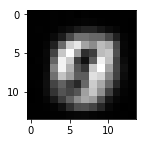

Epoch:  271  Loss:  651592.8085420211
Epoch:  272  Loss:  651636.0922769649
Epoch:  273  Loss:  651502.733617711
Epoch:  274  Loss:  652204.5227975086
Epoch:  275  Loss:  652132.6968963693


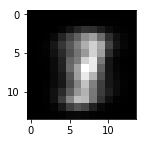

Epoch:  276  Loss:  651737.2212801387
Epoch:  277  Loss:  652117.1532700398
Epoch:  278  Loss:  651686.8740801627
Epoch:  279  Loss:  652536.3462498626
Epoch:  280  Loss:  652214.6779852697


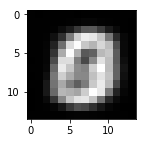

Epoch:  281  Loss:  652236.0466807574
Epoch:  282  Loss:  652146.3582540185
Epoch:  283  Loss:  652326.3154842904
Epoch:  284  Loss:  652755.7826890397
Epoch:  285  Loss:  653048.6437912757


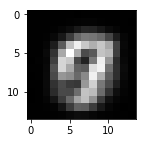

Epoch:  286  Loss:  653307.3037530071
Epoch:  287  Loss:  652723.7572830375
Epoch:  288  Loss:  652129.5221210239
Epoch:  289  Loss:  652760.4244262208
Epoch:  290  Loss:  653100.3647103198


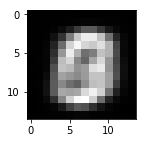

Epoch:  291  Loss:  653124.5635472209
Epoch:  292  Loss:  653717.6580197364
Epoch:  293  Loss:  653360.5800214006
Epoch:  294  Loss:  653775.7488449055
Epoch:  295  Loss:  653793.6435741297


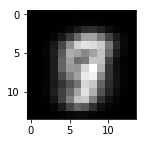

Epoch:  296  Loss:  653958.1215727024
Epoch:  297  Loss:  654861.9629776618
Epoch:  298  Loss:  655384.8125024863
Epoch:  299  Loss:  653989.2312786452
Epoch:  300  Loss:  654709.3741278896


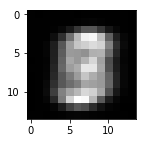

Done Training


In [27]:
vae4 = VAE(input_dim=196, latent_dim=3, learn_rate=5e-4)
vae4.train(x_train=x_train, epochs=300, batch_size=600, shuffle=True)

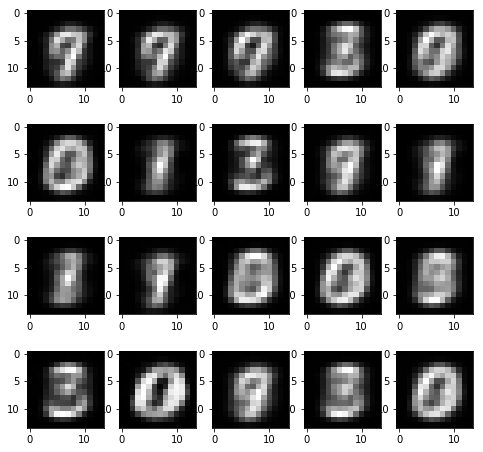

In [28]:
fig=plt.figure(figsize=(8, 8))

for i in range(1, 21):
    z = np.random.normal(0, 1, vae4.latent_dim)
    img = vae4.decoder(z).reshape((14,14))
    fig.add_subplot(4, 5, i)
    plt.imshow(img, cmap='gray')
plt.show()

Epoch:  1  Loss:  2449097.706991492
Epoch:  2  Loss:  1057248.8816472753
Epoch:  3  Loss:  860909.5617785378
Epoch:  4  Loss:  810459.9763723399
Epoch:  5  Loss:  795310.132828863


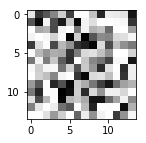

Epoch:  6  Loss:  785754.165791784
Epoch:  7  Loss:  778842.059964559
Epoch:  8  Loss:  774139.0193466279
Epoch:  9  Loss:  770596.1658200667
Epoch:  10  Loss:  767263.5333309106


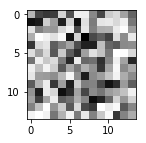

Epoch:  11  Loss:  764763.9662623416
Epoch:  12  Loss:  762400.3555336326
Epoch:  13  Loss:  760276.8786413198
Epoch:  14  Loss:  758454.8893535755
Epoch:  15  Loss:  756512.1599545429


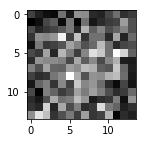

Epoch:  16  Loss:  755073.0021406543
Epoch:  17  Loss:  753992.9377248157
Epoch:  18  Loss:  752895.7803658571
Epoch:  19  Loss:  752076.2567192956
Epoch:  20  Loss:  750644.9926751067


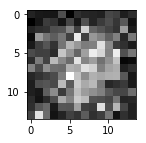

Epoch:  21  Loss:  749909.4276530677
Epoch:  22  Loss:  749179.1046966519
Epoch:  23  Loss:  748546.5487942166
Epoch:  24  Loss:  747814.9420524209
Epoch:  25  Loss:  747290.3749242255


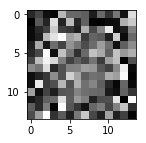

Epoch:  26  Loss:  746633.9623245732
Epoch:  27  Loss:  746285.5539494641
Epoch:  28  Loss:  745709.7864661189
Epoch:  29  Loss:  745279.6340929447
Epoch:  30  Loss:  745008.447323345


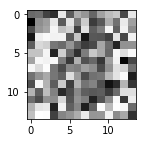

Epoch:  31  Loss:  744655.5665257409
Epoch:  32  Loss:  744339.313742017
Epoch:  33  Loss:  744248.5688926338
Epoch:  34  Loss:  743527.070838897
Epoch:  35  Loss:  743376.2192058929


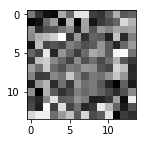

Epoch:  36  Loss:  743155.3686814604
Epoch:  37  Loss:  742739.1654192437
Epoch:  38  Loss:  742794.7196380195
Epoch:  39  Loss:  742653.9436545534
Epoch:  40  Loss:  742259.9262281096


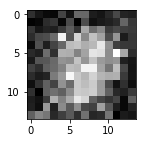

Epoch:  41  Loss:  741985.7049736585
Epoch:  42  Loss:  741975.1688266435
Epoch:  43  Loss:  741582.4979028163
Epoch:  44  Loss:  741506.029414392
Epoch:  45  Loss:  741299.914048776


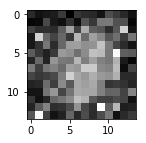

Epoch:  46  Loss:  741258.3741139309
Epoch:  47  Loss:  741039.3346047173
Epoch:  48  Loss:  740853.7071522222
Epoch:  49  Loss:  740843.8860104294
Epoch:  50  Loss:  740807.3151587293


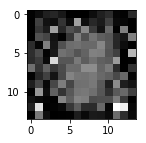

Epoch:  51  Loss:  740656.8498288499
Epoch:  52  Loss:  740604.7721324476
Epoch:  53  Loss:  740391.4111150899
Epoch:  54  Loss:  740452.4159203231
Epoch:  55  Loss:  740219.3683621582


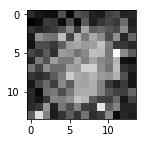

Epoch:  56  Loss:  740286.9685082526
Epoch:  57  Loss:  740165.88583337
Epoch:  58  Loss:  740173.1033419654
Epoch:  59  Loss:  739894.0131319828
Epoch:  60  Loss:  739866.2679644251


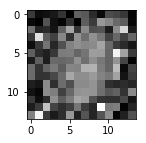

Epoch:  61  Loss:  739891.2784401089
Epoch:  62  Loss:  739820.7233055084
Epoch:  63  Loss:  739816.4031133689
Epoch:  64  Loss:  739734.6474251719
Epoch:  65  Loss:  739837.2766613278


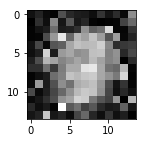

Epoch:  66  Loss:  739795.5327259694
Epoch:  67  Loss:  739618.5041786024
Epoch:  68  Loss:  739636.9885714949
Epoch:  69  Loss:  739693.7019590125
Epoch:  70  Loss:  739645.9023123331


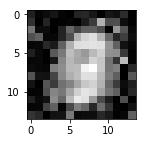

Epoch:  71  Loss:  739695.3399231412
Epoch:  72  Loss:  739548.7082732454
Epoch:  73  Loss:  739632.1855314906
Epoch:  74  Loss:  739783.8558866027
Epoch:  75  Loss:  740011.0899105933


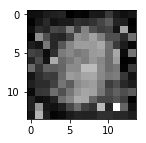

Epoch:  76  Loss:  740064.1023915976
Epoch:  77  Loss:  740415.9823420391
Epoch:  78  Loss:  740484.2664687149
Epoch:  79  Loss:  740890.0840074755
Epoch:  80  Loss:  740969.5553901984


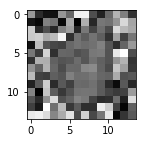

Epoch:  81  Loss:  741461.7537034708
Epoch:  82  Loss:  741756.7315544751
Epoch:  83  Loss:  742167.8899988
Epoch:  84  Loss:  742370.7729334967
Epoch:  85  Loss:  742872.9271014148


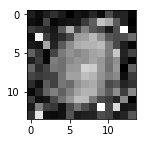

Epoch:  86  Loss:  743062.3862373952
Epoch:  87  Loss:  743774.3339574932
Epoch:  88  Loss:  744089.0048335488
Epoch:  89  Loss:  744226.8078292313
Epoch:  90  Loss:  744107.7211304414


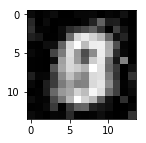

Epoch:  91  Loss:  742472.4749451948
Epoch:  92  Loss:  740418.5149172012
Epoch:  93  Loss:  737132.501302181
Epoch:  94  Loss:  734203.3438845875
Epoch:  95  Loss:  731618.3708241582


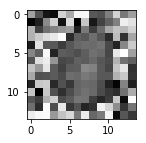

Epoch:  96  Loss:  729034.1824266473
Epoch:  97  Loss:  727083.3218459117
Epoch:  98  Loss:  725309.2577689758
Epoch:  99  Loss:  723504.3793684654
Epoch:  100  Loss:  721660.8873857217


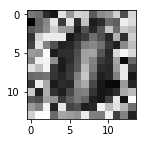

Epoch:  101  Loss:  720137.1605512956
Epoch:  102  Loss:  719283.072893333
Epoch:  103  Loss:  717835.8018451093
Epoch:  104  Loss:  716748.2905553108
Epoch:  105  Loss:  715410.0755544553


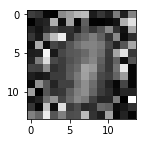

Epoch:  106  Loss:  714442.0736968304
Epoch:  107  Loss:  714326.9127383506
Epoch:  108  Loss:  713182.9454028079
Epoch:  109  Loss:  712671.9631828908
Epoch:  110  Loss:  711623.754949226


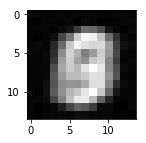

Epoch:  111  Loss:  711785.0003500362
Epoch:  112  Loss:  711216.0510656674
Epoch:  113  Loss:  710678.7759487026
Epoch:  114  Loss:  710096.7883569833
Epoch:  115  Loss:  710170.3290327336


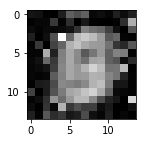

Epoch:  116  Loss:  709734.3172635741
Epoch:  117  Loss:  709815.1187616282
Epoch:  118  Loss:  709290.533957732
Epoch:  119  Loss:  709292.3659366394
Epoch:  120  Loss:  708998.2289237762


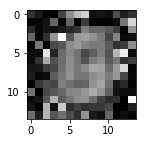

Epoch:  121  Loss:  708424.4739338309
Epoch:  122  Loss:  708755.6242748701
Epoch:  123  Loss:  708209.679956929
Epoch:  124  Loss:  708041.6671818007
Epoch:  125  Loss:  707891.341577189


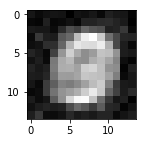

Epoch:  126  Loss:  707456.7874498582
Epoch:  127  Loss:  706828.5683608153
Epoch:  128  Loss:  706416.5862535536
Epoch:  129  Loss:  706302.4082110161
Epoch:  130  Loss:  705621.3973625144


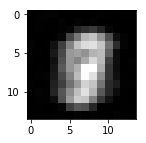

Epoch:  131  Loss:  704954.4169880601
Epoch:  132  Loss:  704180.8254627205
Epoch:  133  Loss:  703873.1080576853
Epoch:  134  Loss:  703607.6326019156
Epoch:  135  Loss:  704699.040562653


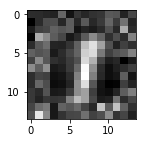

Epoch:  136  Loss:  705021.3338040481
Epoch:  137  Loss:  706267.3700642152
Epoch:  138  Loss:  707176.9381340457
Epoch:  139  Loss:  709438.3514577203
Epoch:  140  Loss:  712091.9739882768


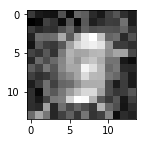

Epoch:  141  Loss:  715628.9135778364
Epoch:  142  Loss:  719239.3099978082
Epoch:  143  Loss:  724098.3774521493
Epoch:  144  Loss:  726903.3941564183
Epoch:  145  Loss:  730040.0649192363


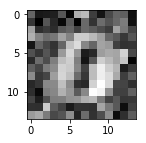

Epoch:  146  Loss:  730461.6190578751
Epoch:  147  Loss:  729628.3847883178
Epoch:  148  Loss:  728376.2207381367
Epoch:  149  Loss:  727212.9019586773
Epoch:  150  Loss:  725525.6118756265


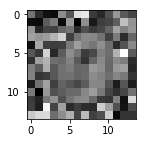

Epoch:  151  Loss:  723910.2075895014
Epoch:  152  Loss:  721852.4735034375
Epoch:  153  Loss:  720943.9072756732
Epoch:  154  Loss:  719122.5875377444
Epoch:  155  Loss:  717351.4857721492


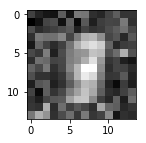

Epoch:  156  Loss:  715651.4205255335
Epoch:  157  Loss:  714668.5297524177
Epoch:  158  Loss:  713644.8606478812
Epoch:  159  Loss:  712249.2615695884
Epoch:  160  Loss:  711115.5919046813


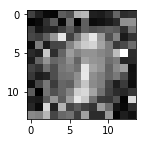

Epoch:  161  Loss:  709644.9693344708
Epoch:  162  Loss:  708653.0356441273
Epoch:  163  Loss:  707341.4668668738
Epoch:  164  Loss:  706521.0927499565
Epoch:  165  Loss:  705581.4710439502


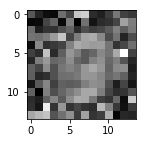

Epoch:  166  Loss:  704680.5857035789
Epoch:  167  Loss:  703377.7992247024
Epoch:  168  Loss:  702448.6516763333
Epoch:  169  Loss:  701856.26004195
Epoch:  170  Loss:  700834.743633924


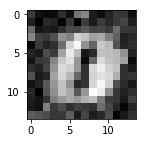

Epoch:  171  Loss:  700552.7297304902
Epoch:  172  Loss:  699666.7832415742
Epoch:  173  Loss:  698939.4805744062
Epoch:  174  Loss:  698221.3920901188
Epoch:  175  Loss:  697875.8794959026


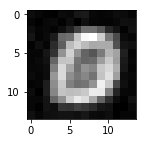

Epoch:  176  Loss:  697530.3624652768
Epoch:  177  Loss:  696723.8672341917
Epoch:  178  Loss:  696837.2837010792
Epoch:  179  Loss:  695821.937708868
Epoch:  180  Loss:  695818.689747004


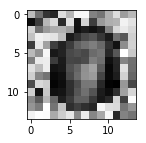

Epoch:  181  Loss:  695575.3904230826
Epoch:  182  Loss:  695297.4337004607
Epoch:  183  Loss:  695442.5230105572
Epoch:  184  Loss:  696466.5345283967
Epoch:  185  Loss:  698889.709707518


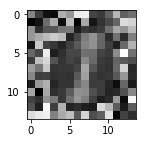

Epoch:  186  Loss:  702213.5877293919
Epoch:  187  Loss:  705198.3884717624
Epoch:  188  Loss:  705603.5257831274
Epoch:  189  Loss:  706152.7279647555
Epoch:  190  Loss:  705075.6110414441


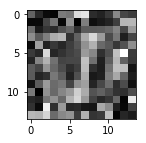

Epoch:  191  Loss:  703496.3511550962
Epoch:  192  Loss:  702137.3938077288
Epoch:  193  Loss:  700416.5641875883
Epoch:  194  Loss:  698505.5982681197
Epoch:  195  Loss:  696760.4074755172


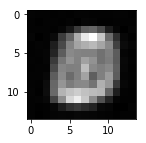

Epoch:  196  Loss:  694114.7753553198
Epoch:  197  Loss:  692972.3840646874
Epoch:  198  Loss:  691753.2773722315
Epoch:  199  Loss:  690517.4186286953
Epoch:  200  Loss:  689501.5311579193


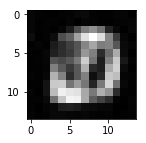

Epoch:  201  Loss:  687591.429390042
Epoch:  202  Loss:  687403.7099138283
Epoch:  203  Loss:  686038.3420913683
Epoch:  204  Loss:  686334.5579298463
Epoch:  205  Loss:  685470.4517905808


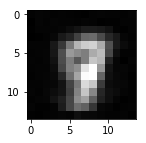

Epoch:  206  Loss:  685330.2807880114
Epoch:  207  Loss:  685054.1170704288
Epoch:  208  Loss:  685029.061489334
Epoch:  209  Loss:  684759.4263922946
Epoch:  210  Loss:  684037.3011110887


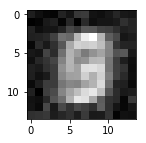

Epoch:  211  Loss:  684271.6634427856
Epoch:  212  Loss:  684084.0186149412
Epoch:  213  Loss:  684548.5510295155
Epoch:  214  Loss:  684384.6681200935
Epoch:  215  Loss:  684447.5658439099


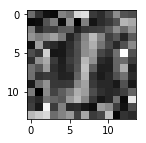

Epoch:  216  Loss:  684858.6327629589
Epoch:  217  Loss:  684642.6975112341
Epoch:  218  Loss:  684646.628881615
Epoch:  219  Loss:  685199.6410920792
Epoch:  220  Loss:  685230.1529853838


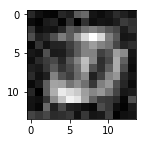

Epoch:  221  Loss:  685120.9780643457
Epoch:  222  Loss:  686183.7979542745
Epoch:  223  Loss:  685743.4072324883
Epoch:  224  Loss:  686428.5737253944
Epoch:  225  Loss:  686699.849808733


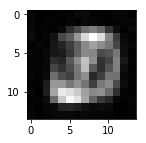

Epoch:  226  Loss:  686818.8004586076
Epoch:  227  Loss:  687343.2203098657
Epoch:  228  Loss:  687241.3641089299
Epoch:  229  Loss:  687955.732744361
Epoch:  230  Loss:  688062.958453591


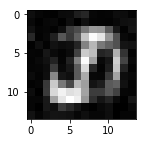

Epoch:  231  Loss:  688436.915231108
Epoch:  232  Loss:  688811.6559087676
Epoch:  233  Loss:  688755.4900334544
Epoch:  234  Loss:  689328.2499374205
Epoch:  235  Loss:  689895.0755562715


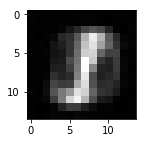

Epoch:  236  Loss:  689664.5452255527
Epoch:  237  Loss:  690020.7293894433
Epoch:  238  Loss:  690472.5529324235
Epoch:  239  Loss:  690108.2348993619
Epoch:  240  Loss:  690583.8245551465


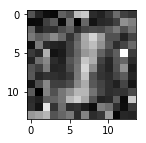

Epoch:  241  Loss:  690533.4096326926
Epoch:  242  Loss:  690615.2493504508
Epoch:  243  Loss:  690134.915141313
Epoch:  244  Loss:  690074.4391908442
Epoch:  245  Loss:  689917.711909874


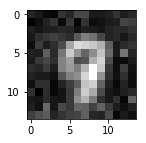

Epoch:  246  Loss:  689766.5268951328
Epoch:  247  Loss:  689061.212110857
Epoch:  248  Loss:  688246.9972111412
Epoch:  249  Loss:  688114.874128682
Epoch:  250  Loss:  687655.5852631028


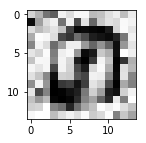

Epoch:  251  Loss:  687218.9572049862
Epoch:  252  Loss:  686381.7922760494
Epoch:  253  Loss:  685867.6853039409
Epoch:  254  Loss:  685179.2635144683
Epoch:  255  Loss:  684645.2139311141


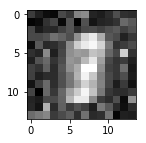

Epoch:  256  Loss:  683528.6799227706
Epoch:  257  Loss:  683649.2029291224
Epoch:  258  Loss:  683182.8959780837
Epoch:  259  Loss:  682501.1363090391
Epoch:  260  Loss:  682066.607563814


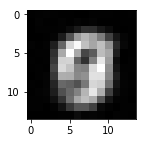

Epoch:  261  Loss:  681840.8954497222
Epoch:  262  Loss:  681350.2790625734
Epoch:  263  Loss:  680332.5455162948
Epoch:  264  Loss:  679373.2250848046
Epoch:  265  Loss:  679446.1338637146


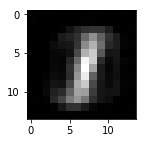

Epoch:  266  Loss:  678166.4812598773
Epoch:  267  Loss:  677192.5701820424
Epoch:  268  Loss:  677095.2327163442
Epoch:  269  Loss:  676605.8934243303
Epoch:  270  Loss:  676134.3441921179


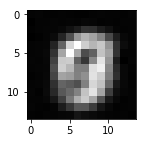

Epoch:  271  Loss:  675568.7687438386
Epoch:  272  Loss:  675076.5061770879
Epoch:  273  Loss:  674156.1667552679
Epoch:  274  Loss:  673831.9128596344
Epoch:  275  Loss:  673564.515734032


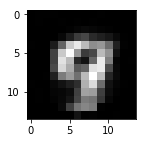

Epoch:  276  Loss:  672575.2309471262
Epoch:  277  Loss:  672775.8711091257
Epoch:  278  Loss:  671984.6325145409
Epoch:  279  Loss:  671396.9651783332
Epoch:  280  Loss:  671472.1893938559


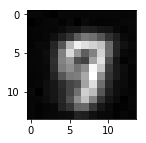

Epoch:  281  Loss:  671083.2079870191
Epoch:  282  Loss:  670561.803223088
Epoch:  283  Loss:  670405.6112005253
Epoch:  284  Loss:  669715.5866694687
Epoch:  285  Loss:  669721.1235199096


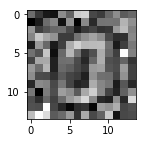

Epoch:  286  Loss:  669388.8514419782
Epoch:  287  Loss:  669560.7581305759
Epoch:  288  Loss:  668887.0861118649
Epoch:  289  Loss:  668767.5454148065
Epoch:  290  Loss:  668512.0858536919


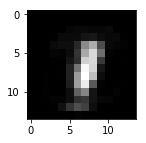

Epoch:  291  Loss:  668408.0784201674
Epoch:  292  Loss:  668390.1697752824
Epoch:  293  Loss:  668251.7975014627
Epoch:  294  Loss:  668118.4032450959
Epoch:  295  Loss:  667904.1272004277


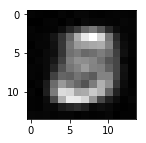

Epoch:  296  Loss:  667624.6704462679
Epoch:  297  Loss:  667805.6924322079
Epoch:  298  Loss:  667379.5058101804
Epoch:  299  Loss:  667492.1915866835
Epoch:  300  Loss:  667352.0161767304


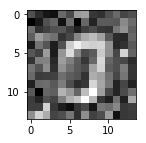

Done Training


In [29]:
vae5 = VAE(input_dim=196, latent_dim=3, learn_rate=1e-4)
vae5.train(x_train=x_train, epochs=300, batch_size=600, shuffle=True)

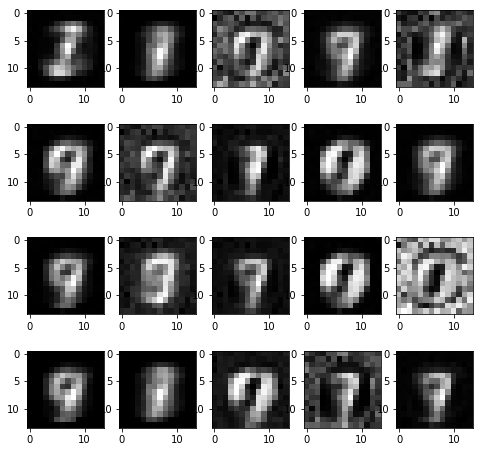

In [30]:
fig=plt.figure(figsize=(8, 8))

for i in range(1, 21):
    z = np.random.normal(0, 1, vae5.latent_dim)
    img = vae5.decoder(z).reshape((14,14))
    fig.add_subplot(4, 5, i)
    plt.imshow(img, cmap='gray')
plt.show()